# Benchmarking results
Run this code before other cells:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as sps

In [2]:
def get_df(filename, data_size=2147483648):
    df = pd.read_csv(filename)
    df = df[df['data_size'] == data_size]
    return df

def total_time(filename, data_size=2147483648):
    df = get_df(filename, data_size)
    total_df = df[['scan time', 'execute_query time']].sum(axis=0)
    scan_min = round(total_df['scan time'] / (60 * 1000), 2)
    execute_query_min = round(total_df['execute_query time'] / (60 * 1000), 2)
    total_min = scan_min + execute_query_min
    print('Scan time: {} min, ExecuteQuery: {} min, Total: {} min'.format(scan_min, execute_query_min, total_min))
    
def survey(filename):
    df = get_df(filename)
    df_mean = df.groupby(['data_size', 'block_size', 'upper_bound','scan thread number', ' execute_query thread number']).mean()
    return df_mean

In [3]:
def setup_axes(ax, xlabel, ylabel):
    for i in range(len(ax)):
        ax[i].legend()
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_xlabel(xlabel, fontsize=12)
        ax[i].set_ylabel(ylabel, fontsize=12)
        
def main_info(filename, data_size=2147483648):
    df = get_df(filename, data_size)
    
    df_main = df[['block_size', 'scan thread number', 'scan time', 'execute_query time', 'upper_bound']]
    df_grouped = df_main.groupby(['block_size', 'scan thread number', 'upper_bound']).mean()

    block_sizes = []
    thread_numbers = []
    upper_bounds = []
    index_list = df_grouped.index.values.tolist()

    for block_size, thread_number, upper_bound in index_list:
        if block_size not in block_sizes:
            block_sizes.append(block_size)
        if thread_number not in thread_numbers:
            thread_numbers.append(thread_number)
        if upper_bound not in upper_bounds:
            upper_bounds.append(upper_bound)
            
    return df, df_main, block_sizes, thread_numbers, upper_bounds
    
def block_size_to_time_relation(filename):
    df, df_main, block_sizes, thread_numbers, _ = main_info(filename)   

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    for thread_number in thread_numbers:
        df_bs = df_main[df_main['scan thread number'] == thread_number].groupby('block_size').mean()
        ax[0].plot(df_bs['scan time'], label='{} threads'.format(thread_number))
        ax[1].plot(df_bs['execute_query time'], label='{} threads'.format(thread_number))

    setup_axes(ax, 'block size', 'time, ms')
    ax[0].set_xticks(block_sizes)
    ax[0].set_xticklabels([str(block_size) for block_size in block_sizes])
    ax[1].set_xticks(block_sizes)
    ax[1].set_xticklabels([str(block_size) for block_size in block_sizes])
    ax[0].set_title('Scan time', fontsize=16)
    ax[1].set_title('ExecuteQuery time', fontsize=16)
    plt.suptitle('Block size and time to run relation', fontsize=18) 
    
    
def thread_number_to_time_relation(filename):
    df, df_main, block_sizes, thread_numbers, _ = main_info(filename)
        
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for block_size in block_sizes:
        df_bs = df_main[df_main['block_size'] == block_size].groupby('scan thread number').mean()
        ax[0].plot(df_bs['scan time'], label='bs={}'.format(block_size))
        ax[1].plot(df_bs['execute_query time'], label='bs={}'.format(block_size))

    setup_axes(ax, 'thread number', 'time, ms')
    ax[0].set_xticks(thread_numbers)
    ax[0].set_xticklabels([str(thread_number) for thread_number in thread_numbers])
    ax[1].set_xticks(thread_numbers)
    ax[1].set_xticklabels([str(thread_number) for thread_number in thread_numbers])
    ax[0].set_title('Scan time', fontsize=16)
    ax[1].set_title('ExecuteQuery time', fontsize=16)
    plt.suptitle('Thread number and time to run relation', fontsize=18)

In [4]:
def setup_axes(ax, xlabel, ylabel):
    for i in range(len(ax)):
        ax[i].legend()
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_xlabel(xlabel, fontsize=12)
        ax[i].set_ylabel(ylabel, fontsize=12)
        
    
def block_size_to_time_relation_02(filename, ax):
    df, df_main, block_sizes, thread_numbers, _ = main_info(filename)   

    for thread_number in thread_numbers:
        df_bs = df_main[df_main['scan thread number'] == thread_number].groupby('block_size').mean()
        ax[0].plot(df_bs['scan time'], label='{} threads'.format(thread_number))
        ax[1].plot(df_bs['execute_query time'], label='{} threads'.format(thread_number))

    setup_axes(ax, 'block size', 'time, ms')
    ax[0].set_xticks(block_sizes)
    ax[0].set_xticklabels([str(block_size) for block_size in block_sizes])
    ax[1].set_xticks(block_sizes)
    ax[1].set_xticklabels([str(block_size) for block_size in block_sizes])
    
    
def thread_number_to_time_relation_02(filename, ax):
    df, df_main, block_sizes, thread_numbers, _ = main_info(filename)
        
    for block_size in block_sizes:
        df_bs = df_main[df_main['block_size'] == block_size].groupby('scan thread number').mean()
        ax[0].plot(df_bs['scan time'], label='bs={}'.format(block_size))
        ax[1].plot(df_bs['execute_query time'], label='bs={}'.format(block_size))

    setup_axes(ax, 'thread number', 'time, ms')
    ax[0].set_xticks(thread_numbers)
    ax[0].set_xticklabels([str(thread_number) for thread_number in thread_numbers])
    ax[1].set_xticks(thread_numbers)
    ax[1].set_xticklabels([str(thread_number) for thread_number in thread_numbers])

In [5]:
def split_by_upper_bound(filename, upper_bound, data_size=2147483648):
    df = get_df(filename, data_size)
    
    df_main = df[['block_size', 'scan thread number', 'scan time', 'execute_query time', 'upper_bound']]
    if upper_bound != -100:
        df_main = df_main[df_main['upper_bound'] == upper_bound]
    df_grouped = df_main.groupby(['block_size', 'scan thread number', 'upper_bound']).mean()

    block_sizes = []
    thread_numbers = []
    upper_bounds = []
    index_list = df_grouped.index.values.tolist()

    for block_size, thread_number, upper_bound in index_list:
        if block_size not in block_sizes:
            block_sizes.append(block_size)
        if thread_number not in thread_numbers:
            thread_numbers.append(thread_number)
        if upper_bound not in upper_bounds:
            upper_bounds.append(upper_bound)
            
    return df_main, df_grouped, block_sizes, thread_numbers, upper_bounds

def get_mean_time(filename, block_size, thread_number, upper_bound, data_size=2147483648):
    df_main, df_grouped, block_sizes, thread_numbers, _ = split_by_upper_bound(filename, upper_bound, data_size)
    stamp = df_main[(df_main['block_size'] == block_size) & (df_main['scan thread number'] == thread_number)]
    stamp = stamp[['scan time', 'execute_query time']].mean()
    return stamp['scan time'], stamp['execute_query time']
    
def get_EQ_time(filename, block_size, thread_number, upper_bound):
    scan_time, execute_query_time = get_mean_time(filename, block_size, thread_number, upper_bound)
    return execute_query_time

## Evaluation

In [3]:
print('RoundRobin survey:')
total_time('log_round_robin_01.csv')
print('OneDisk survey:')
total_time('log_one_disk_01.csv')

RoundRobin survey:
Scan time: 0.0 min, ExecuteQuery: 0.0 min, Total: 0.0 min
OneDisk survey:
Scan time: 0.0 min, ExecuteQuery: 0.0 min, Total: 0.0 min


In [95]:
survey('log_round_robin_01.csv')

scan time  \
data_size  block_size upper_bound scan thread number  execute_query thread number              
1073741824 512        22          1                  1                             22647.750   
                                  2                  2                             11420.250   
                                  4                  4                              5974.875   
                                  8                  8                              3646.250   
                                  16                 16                             7639.375   
           1024       22          1                  1                             11783.750   
                                  2                  2                              5992.250   
                                  4                  4                              3177.750   
                                  8                  8                              2275.000   
                                  16                 16                             4418.250   
           2048       22          1                  1                              6690.500   
                                  2                  2                              3428.500   
                                  4                  4                              1907.750   
                                  8                  8                              1118.375   
                                  16                 16                             2261.250   
           4096       22          1                  1                              4545.250   
                                  2                  2                              2150.875   
                                  4                  4                              1174.500   
                                  8                  8                              1407.000   
                                  16                 16                             1198.125   
           8192       22          1                  1                              2993.000   
                                  2                  2                              1353.500   
                                  4                  4                               803.250   
                                  8                  8                               637.500   
                                  16                 16                              685.125   

                                                                                   execute_query time  
data_size  block_size upper_bound scan thread number  execute_query thread number                      
1073741824 512        22          1                  1                                      70230.875  
                                  2                  2                                      46949.000  
                                  4                  4                                      24285.375  
                                  8                  8                                      13281.750  
                                  16                 16                                      6932.625  
           1024       22          1                  1                                      38250.875  
                                  2                  2                                      23688.625  
                                  4                  4                                      12223.125  
                                  8                  8                                       6657.750  
                                  16                 16                                      3523.625  
           2048       22          1                  1                                      19285.000  
                                  2                  2                                      12165.500  
                                  

In [96]:
survey('log_one_disk_01.csv')

scan time  \
data_size  block_size upper_bound scan thread number  execute_query thread number               
1073741824 512        22          1                  1                             193072.750   
                                  2                  2                              97029.000   
                                  4                  4                              49002.750   
                                  8                  8                              25188.000   
                                  16                 16                             13758.625   
           1024       22          1                  1                              97216.625   
                                  2                  2                              48838.500   
                                  4                  4                              24842.875   
                                  8                  8                              12812.875   
                                  16                 16                              6988.625   
           2048       22          1                  1                              48921.000   
                                  2                  2                              24631.750   
                                  4                  4                              12459.625   
                                  8                  8                               6389.500   
                                  16                 16                              3456.750   
           4096       22          1                  1                              25930.125   
                                  2                  2                              13082.375   
                                  4                  4                               6613.375   
                                  8                  8                               3356.625   
                                  16                 16                              1786.875   
           8192       22          1                  1                              14960.375   
                                  2                  2                               7549.000   
                                  4                  4                               3829.750   
                                  8                  8                               1927.625   
                                  16                 16                              1037.875   

                                                                                   execute_query time  
data_size  block_size upper_bound scan thread number  execute_query thread number                      
1073741824 512        22          1                  1                                     150354.750  
                                  2                  2                                      77947.750  
                                  4                  4                                      39204.375  
                                  8                  8                                      19944.375  
                                  16                 16                                     10832.125  
           1024       22          1                  1                                      77081.375  
                                  2                  2                                      39203.250  
                                  4                  4                                      19975.250  
                                  8                  8                                      10267.375  
                                  16                 16                                      5509.750  
           2048       22          1                  1                                      40413.750  
                                  2                  2                                      20330.500  
        

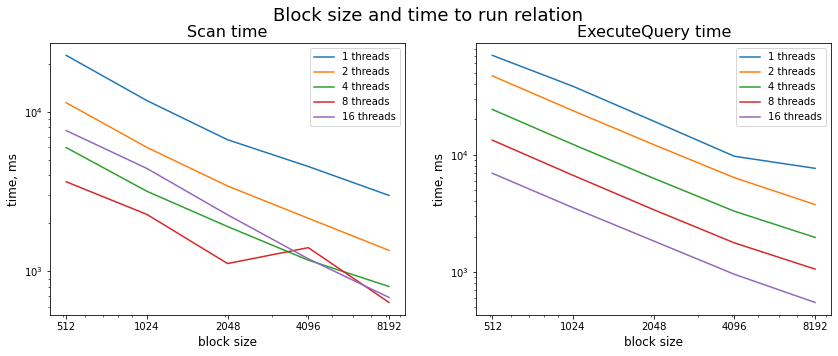

In [105]:
block_size_to_time_relation('log_round_robin_01.csv')

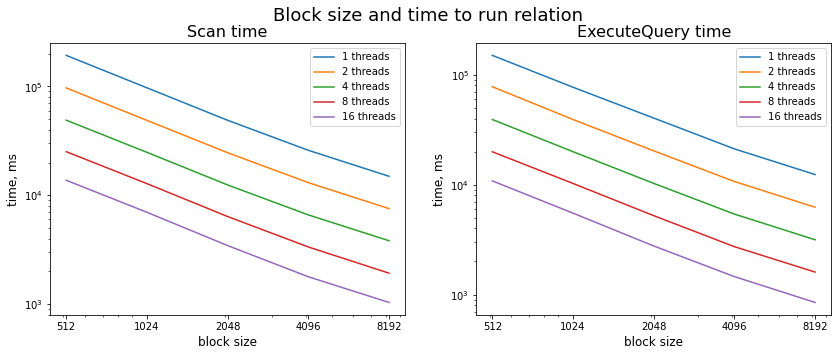

In [106]:
block_size_to_time_relation('log_one_disk_01.csv')

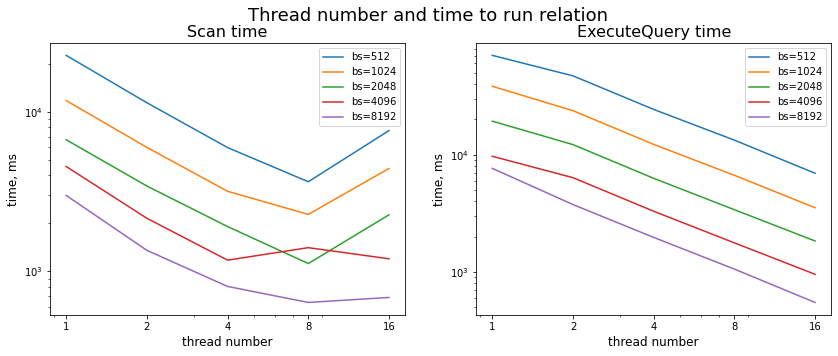

In [107]:
thread_number_to_time_relation('log_round_robin_01.csv')

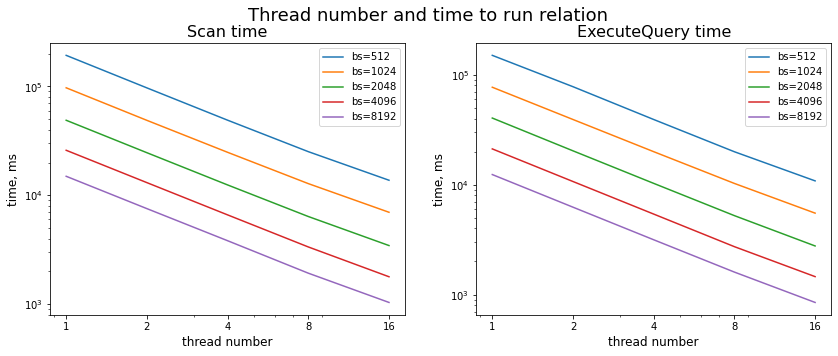

In [108]:
thread_number_to_time_relation('log_one_disk_01.csv')

In [4]:
rr, rr_main, block_sizes, thread_numbers, _ = main_info('log_round_robin_01.csv')
od, od_main, block_sizes, thread_numbers, _ = main_info('log_one_disk_01.csv')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
for thread_number in thread_numbers:
    rr_bs = rr_main[rr_main['scan thread number'] == thread_number].groupby('block_size').mean()
    od_bs = od_main[od_main['scan thread number'] == thread_number].groupby('block_size').mean()
    ax[0].plot(rr_bs['execute_query time'] / rr_bs['scan time'], label='{} threads'.format(thread_number))
    ax[1].plot(od_bs['execute_query time'] / od_bs['scan time'], label='{} threads'.format(thread_number))
    

ax[0].legend()
ax[1].legend()
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_xlabel('block size')
ax[1].set_xlabel('block size')

ax[0].set_xticks(block_sizes)
ax[0].set_xticklabels([str(block_size) for block_size in block_sizes])
ax[1].set_xticks(block_sizes)
ax[1].set_xticklabels([str(block_size) for block_size in block_sizes])
ax[0].set_title('RoundRobin', fontsize=16)
ax[1].set_title('OneDisk', fontsize=16)
ax[0].set_ylabel('execute_query time / scan time')

NameError: name 'main_info' is not defined

## Benchmarks.2
After noticing that using `/scratch` disk for one disk strategy gives strange results, we decided to try using one of `/nvme` disks for one disk placement strategy. Also we decided to try using bigger block sizes to minimize some CPU overhead.

In [2]:
%ls

'Benchmarking results.ipynb'   log_one_disk_02.csv      log_round_robin_02.csv
 expected_ration.csv           log_one_file_02.csv
 log_one_disk_01.csv           log_round_robin_01.csv


In [6]:
print('RoundRobin survey:')
total_time('log_round_robin_02.csv')
print('OneDisk survey:')
total_time('log_one_disk_02.csv')
print('OneFile survey:')
total_time('log_one_file_02.csv')

RoundRobin survey:
Scan time: 126.23 min, ExecuteQuery: 204.98 min, Total: 331.21 min
OneDisk survey:
Scan time: 220.87 min, ExecuteQuery: 246.21 min, Total: 467.08000000000004 min
OneFile survey:
Scan time: 111.61 min, ExecuteQuery: 117.61 min, Total: 229.22 min


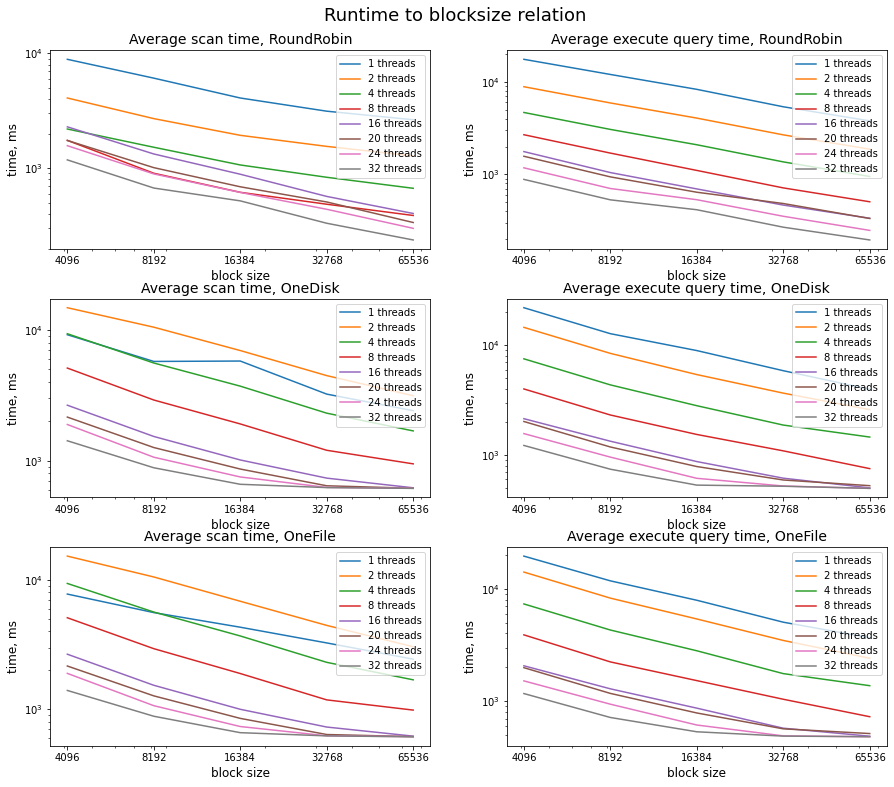

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.25)
block_size_to_time_relation_02('log_round_robin_02.csv', ax[0])
ax[0][0].set_title('Average scan time, RoundRobin', fontsize=14)
ax[0][1].set_title('Average execute query time, RoundRobin', fontsize=14)
block_size_to_time_relation_02('log_one_disk_02.csv', ax[1])
ax[1][0].set_title('Average scan time, OneDisk', fontsize=14)
ax[1][1].set_title('Average execute query time, OneDisk', fontsize=14)
block_size_to_time_relation_02('log_one_file_02.csv', ax[2])
ax[2][0].set_title('Average scan time, OneFile', fontsize=14)
ax[2][1].set_title('Average execute query time, OneFile', fontsize=14)
plt.suptitle('Runtime to blocksize relation', fontsize=18)
plt.subplots_adjust(top=0.93)

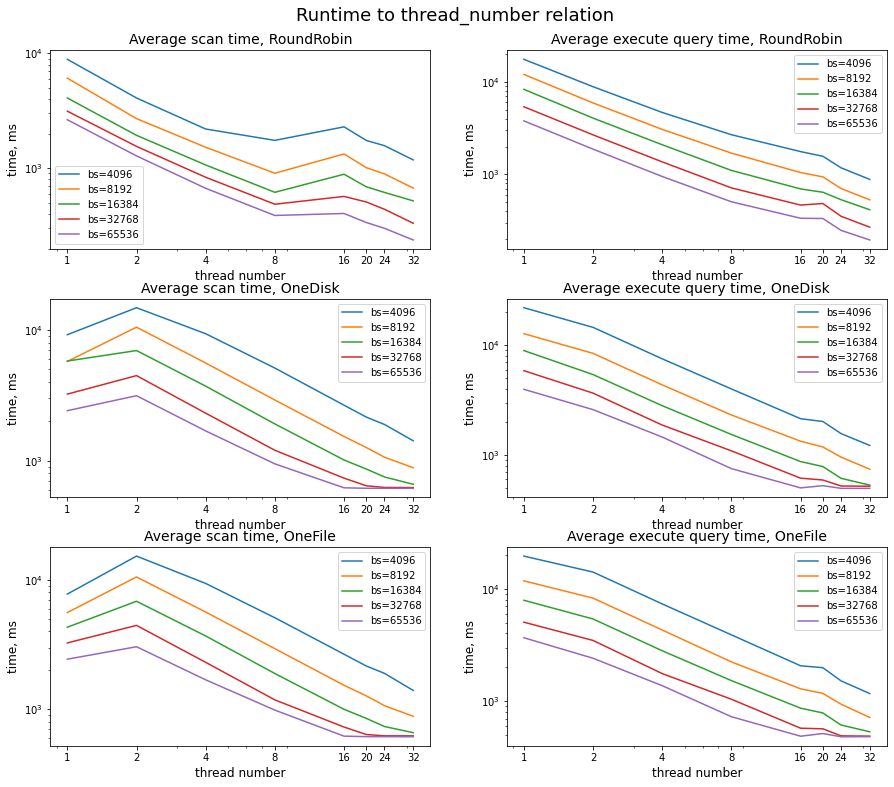

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.25)
thread_number_to_time_relation_02('log_round_robin_02.csv', ax[0])
ax[0][0].set_title('Average scan time, RoundRobin', fontsize=14)
ax[0][1].set_title('Average execute query time, RoundRobin', fontsize=14)
thread_number_to_time_relation_02('log_one_disk_02.csv', ax[1])
ax[1][0].set_title('Average scan time, OneDisk', fontsize=14)
ax[1][1].set_title('Average execute query time, OneDisk', fontsize=14)
thread_number_to_time_relation_02('log_one_file_02.csv', ax[2])
ax[2][0].set_title('Average scan time, OneFile', fontsize=14)
ax[2][1].set_title('Average execute query time, OneFile', fontsize=14)
plt.suptitle('Runtime to thread_number relation', fontsize=18)
plt.subplots_adjust(top=0.93)

Let us compare the strategies with different upper bounds.

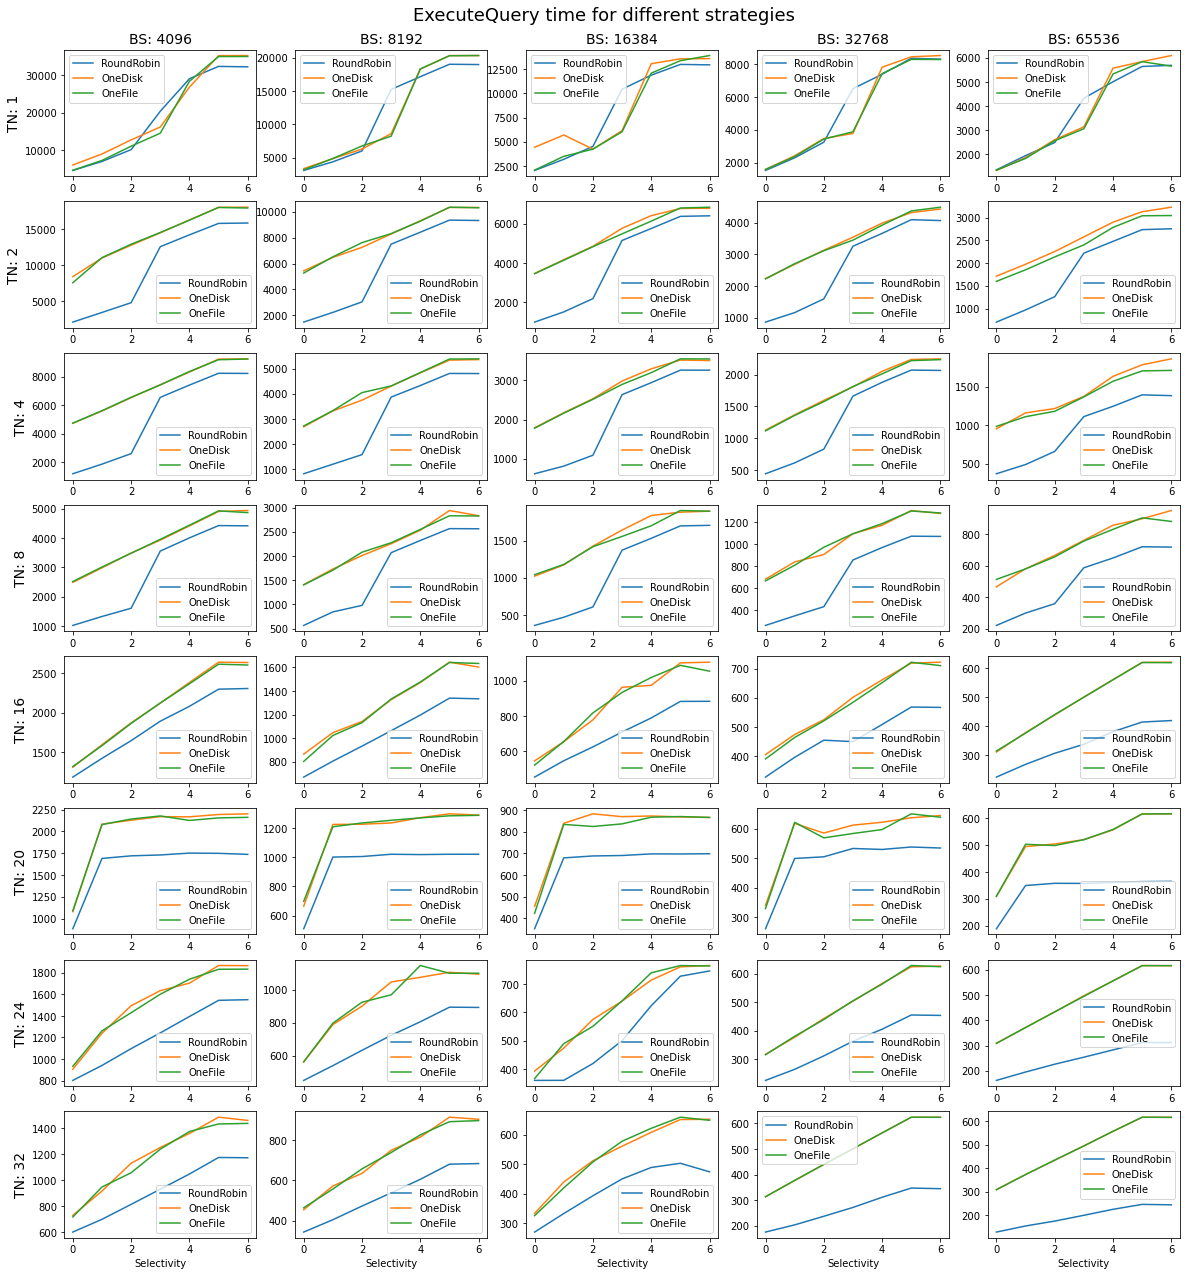

In [11]:
_, _, block_sizes, thread_numbers, upper_bounds = main_info('log_round_robin_02.csv')
fig, ax = plt.subplots(nrows=len(thread_numbers), ncols=len(block_sizes), figsize=(20, 20))

for i, thread_number in enumerate(thread_numbers):
    for j, block_size in enumerate(block_sizes):
        ax[0][j].set_title('BS: {}'.format(block_size), fontsize=14)
        ax[len(thread_numbers) - 1][j].set_xlabel('Selectivity')
        arr_round_robin = []
        arr_one_disk = []
        arr_one_file = []
        for upper_bound in upper_bounds:
            arr_round_robin.append(get_mean_time('log_round_robin_02.csv', block_size, thread_number, upper_bound)[1])
            arr_one_disk.append(get_mean_time('log_one_disk_02.csv', block_size, thread_number, upper_bound)[1])
            arr_one_file.append(get_mean_time('log_one_file_02.csv', block_size, thread_number, upper_bound)[1])
        ax[i][j].plot(arr_round_robin, label='RoundRobin')
        ax[i][j].plot(arr_one_disk, label='OneDisk')
        ax[i][j].plot(arr_one_file, label='OneFile')
        ax[i][j].legend()
    ax[i][0].set_ylabel('TN: {}'.format(thread_number), fontsize=14)
    
plt.suptitle('ExecuteQuery time for different strategies', fontsize=18)
plt.subplots_adjust(top=0.95)

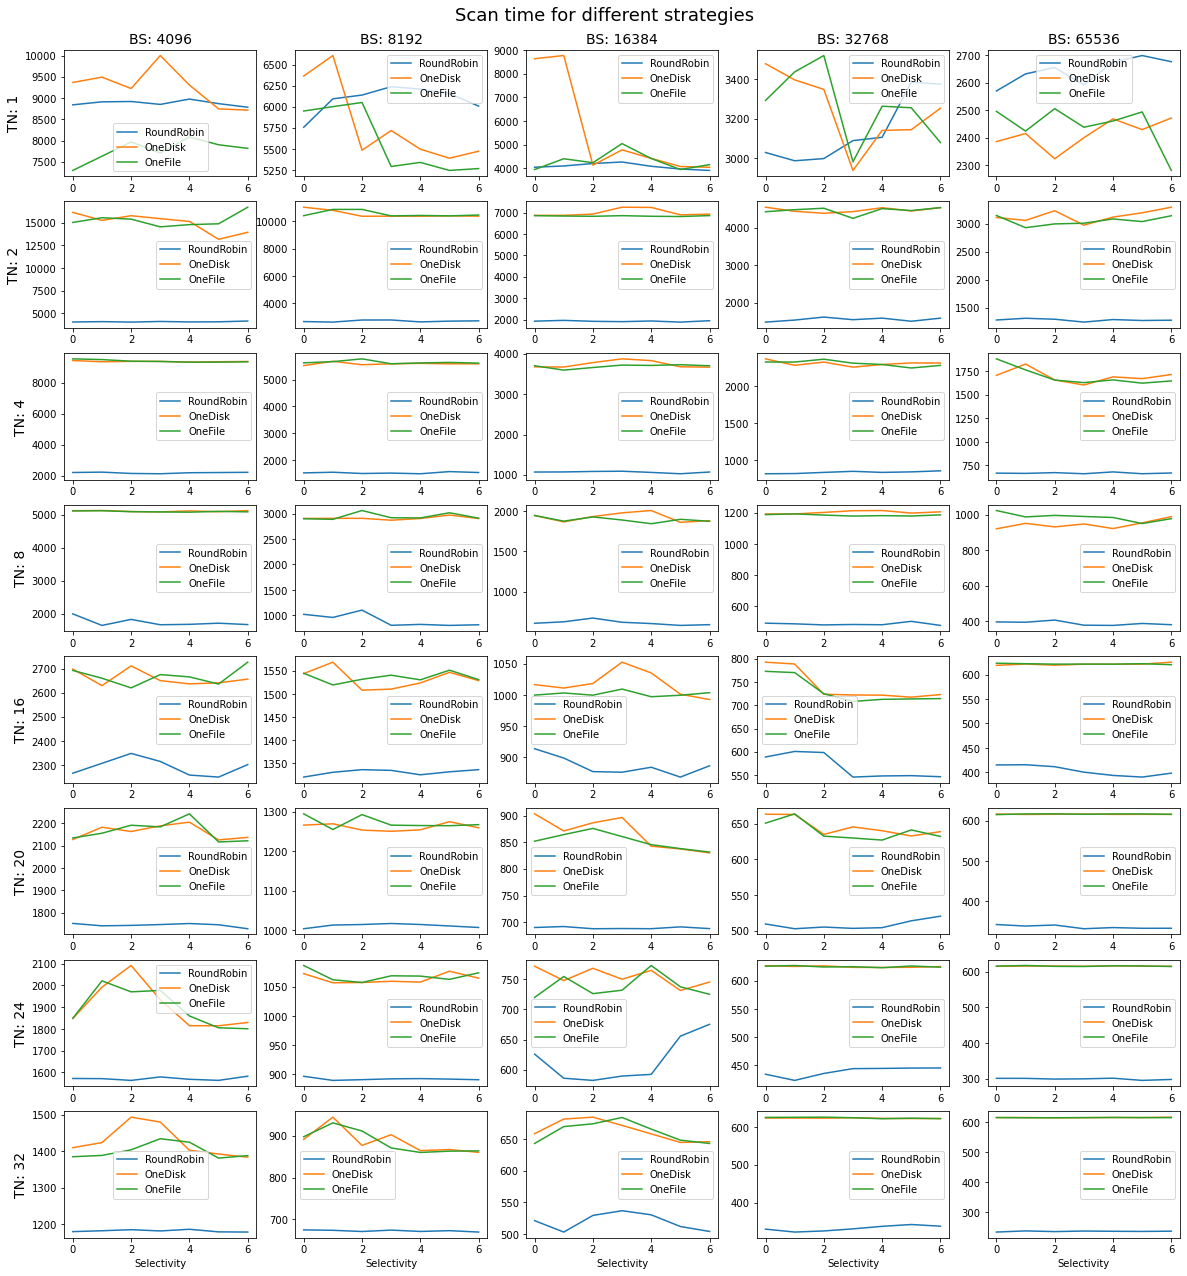

In [12]:
_, _, block_sizes, thread_numbers, upper_bounds = main_info('log_round_robin_02.csv')
fig, ax = plt.subplots(nrows=len(thread_numbers), ncols=len(block_sizes), figsize=(20, 20))

for i, thread_number in enumerate(thread_numbers):
    for j, block_size in enumerate(block_sizes):
        ax[0][j].set_title('BS: {}'.format(block_size), fontsize=14)
        ax[len(thread_numbers) - 1][j].set_xlabel('Selectivity')
        arr_round_robin = []
        arr_one_disk = []
        arr_one_file = []
        for upper_bound in upper_bounds:
            arr_round_robin.append(get_mean_time('log_round_robin_02.csv', block_size, thread_number, upper_bound)[0])
            arr_one_disk.append(get_mean_time('log_one_disk_02.csv', block_size, thread_number, upper_bound)[0])
            arr_one_file.append(get_mean_time('log_one_file_02.csv', block_size, thread_number, upper_bound)[0])
        ax[i][j].plot(arr_round_robin, label='RoundRobin')
        ax[i][j].plot(arr_one_disk, label='OneDisk')
        ax[i][j].plot(arr_one_file, label='OneFile')
        ax[i][j].legend()
    ax[i][0].set_ylabel('TN: {}'.format(thread_number), fontsize=14)
    
plt.suptitle('Scan time for different strategies', fontsize=18)
plt.subplots_adjust(top=0.95)

In [13]:
expected_ratios = pd.read_csv('expected_ration.csv')
expected_ratios.head()

block_size  upper_bound  to_be_loaded  expected_ratio
0        4096           -2      0.000000        0.500000
1        4096            6      0.199856        0.599928
2        4096           14      0.399847        0.699924
3        4096           22      0.599800        0.799900
4        4096           30      0.799837        0.899919

In [14]:
def get_expected_ratio(block_size, upper_bound):
    stamp = expected_ratios[(expected_ratios['block_size'] == block_size) & 
                            (expected_ratios['upper_bound'] == upper_bound)]
    return stamp['expected_ratio'].mean()

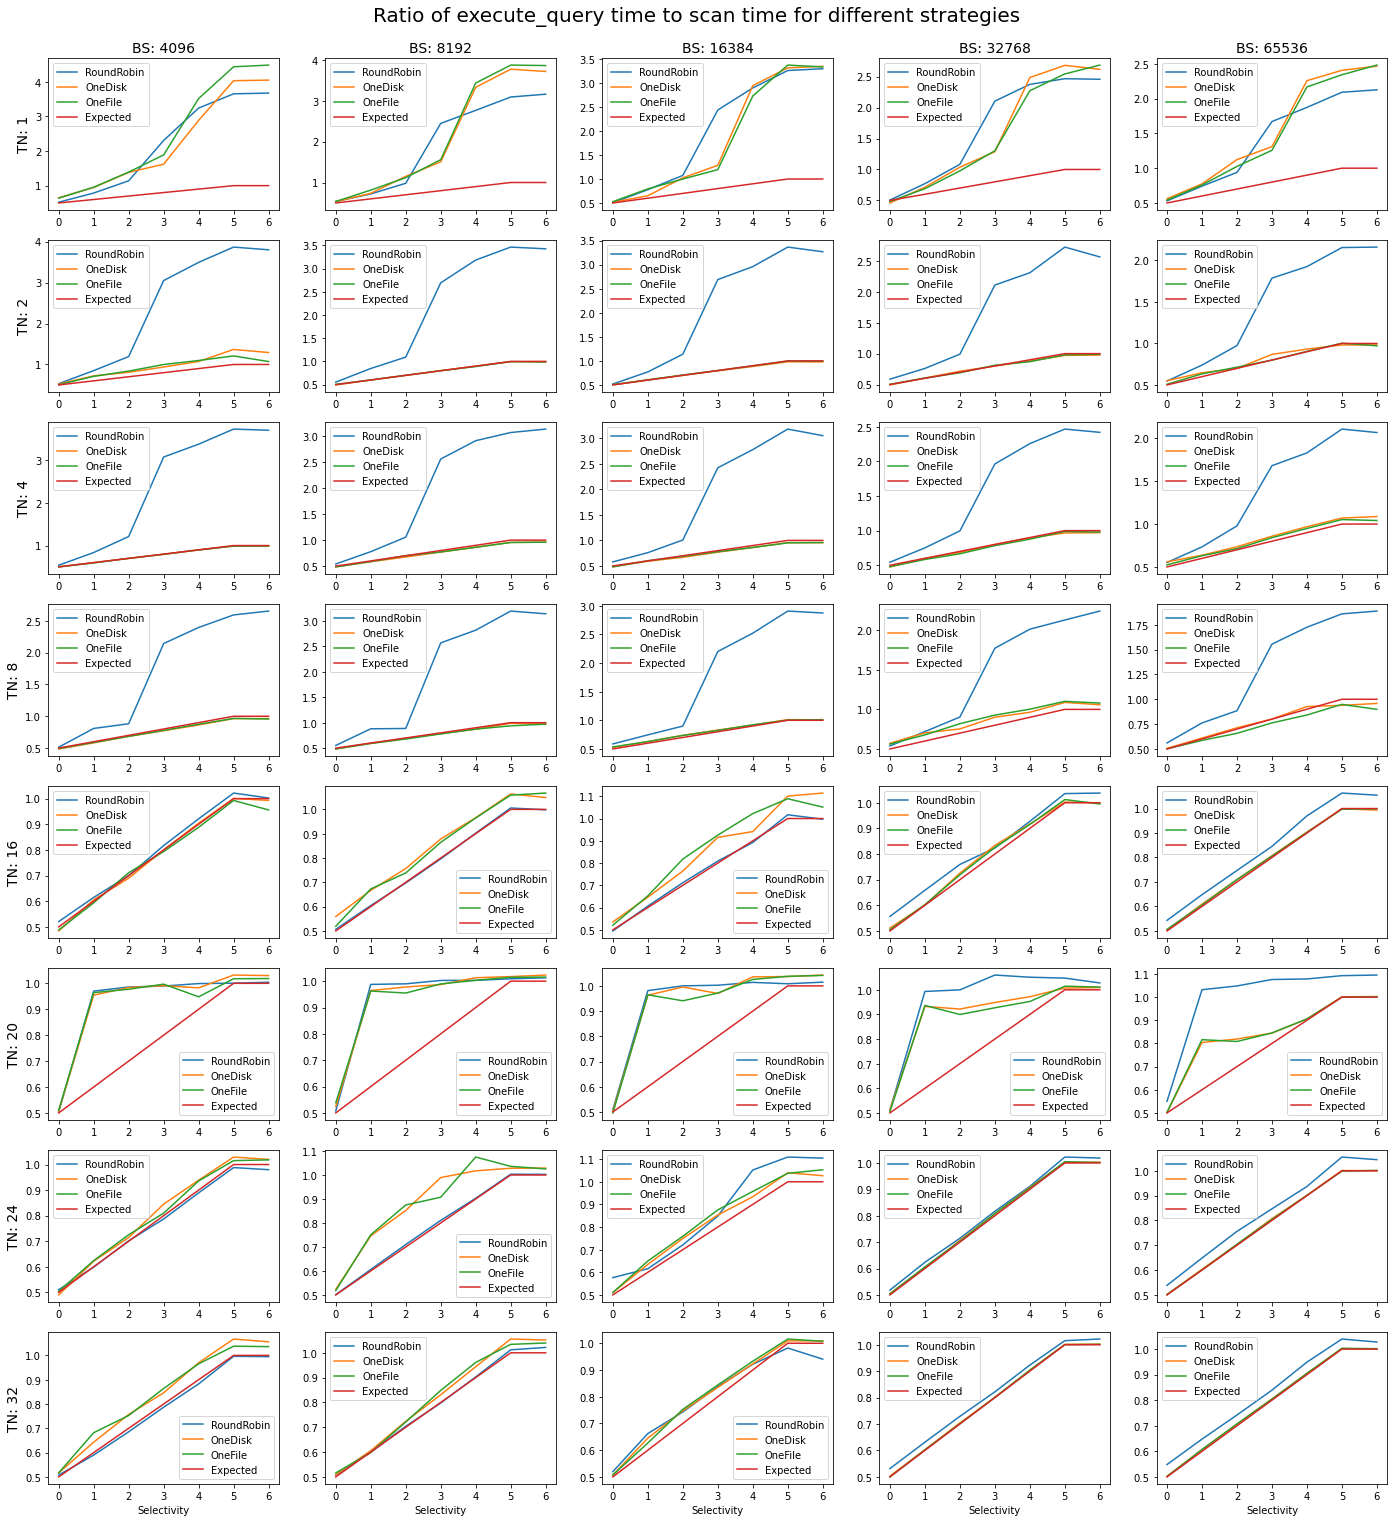

In [15]:
_, _, block_sizes, thread_numbers, upper_bounds = main_info('log_round_robin_02.csv')
fig, ax = plt.subplots(nrows=len(thread_numbers), ncols=len(block_sizes), figsize=(24, 24))

for i, thread_number in enumerate(thread_numbers):
    for j, block_size in enumerate(block_sizes):
        ax[0][j].set_title('BS: {}'.format(block_size), fontsize=14)
        ax[len(thread_numbers) - 1][j].set_xlabel('Selectivity')
        arr_round_robin = []
        arr_one_disk = []
        arr_one_file = []
        arr_expected = []
        for upper_bound in upper_bounds:
            rr_sc, rr_eq = get_mean_time('log_round_robin_02.csv', block_size, thread_number, upper_bound)
            arr_round_robin.append(rr_eq / rr_sc)
            od_sc, od_eq = get_mean_time('log_one_disk_02.csv', block_size, thread_number, upper_bound)
            arr_one_disk.append(od_eq / od_sc)
            of_sc, of_eq = get_mean_time('log_one_file_02.csv', block_size, thread_number, upper_bound)
            arr_one_file.append(of_eq / of_sc)
            arr_expected.append(get_expected_ratio(block_size, upper_bound))
        ax[i][j].plot(arr_round_robin, label='RoundRobin')
        ax[i][j].plot(arr_one_disk, label='OneDisk')
        ax[i][j].plot(arr_one_file, label='OneFile')
        ax[i][j].plot(arr_expected, label='Expected')
        ax[i][j].legend()
    ax[i][0].set_ylabel('TN: {}'.format(thread_number), fontsize=14)
    
plt.suptitle('Ratio of execute_query time to scan time for different strategies', fontsize=20)
plt.subplots_adjust(top=0.95)

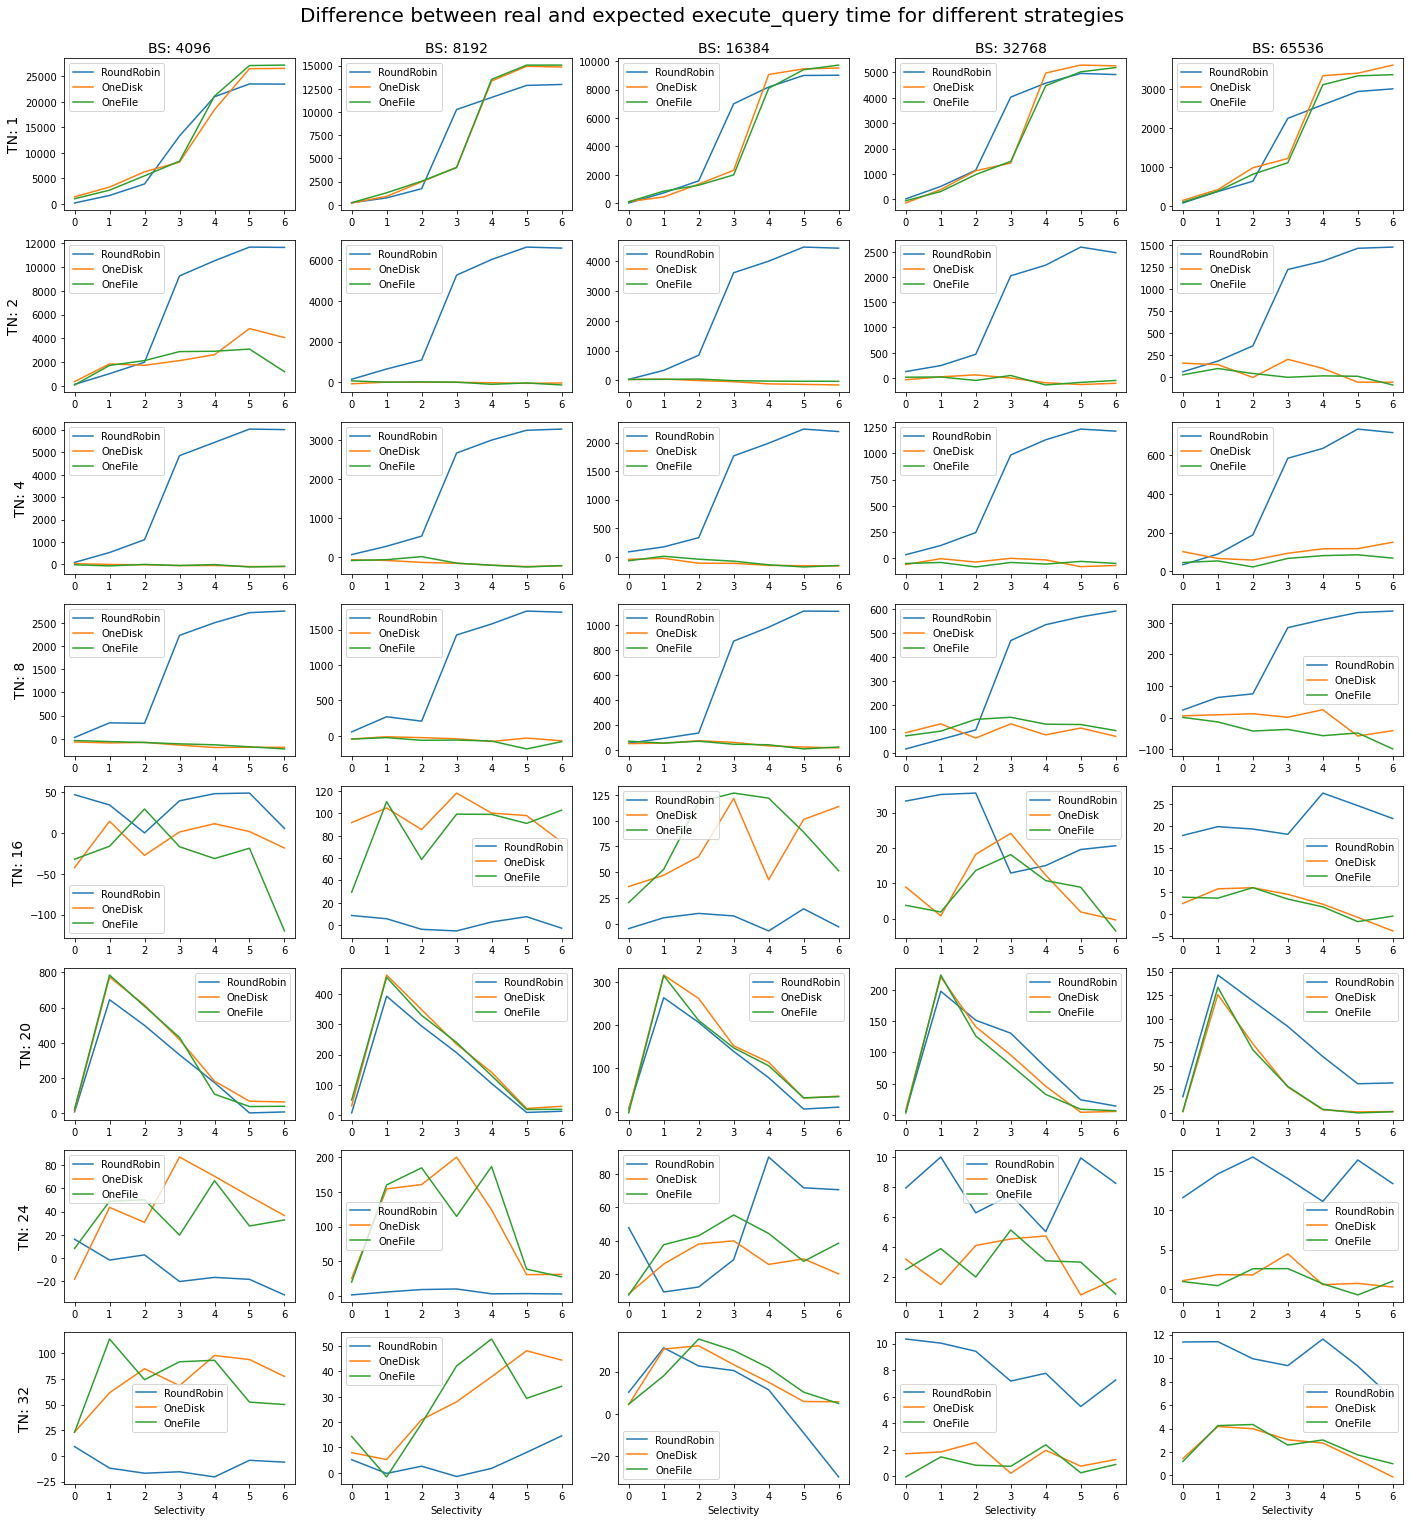

In [16]:
_, _, block_sizes, thread_numbers, upper_bounds = main_info('log_round_robin_02.csv')
fig, ax = plt.subplots(nrows=len(thread_numbers), ncols=len(block_sizes), figsize=(24, 24))

for i, thread_number in enumerate(thread_numbers):
    for j, block_size in enumerate(block_sizes):
        ax[0][j].set_title('BS: {}'.format(block_size), fontsize=14)
        ax[len(thread_numbers) - 1][j].set_xlabel('Selectivity')
        arr_round_robin = []
        arr_one_disk = []
        arr_one_file = []

        for upper_bound in upper_bounds:
            ratio = get_expected_ratio(block_size, upper_bound)
            rr_sc, rr_eq = get_mean_time('log_round_robin_02.csv', block_size, thread_number, upper_bound)
            arr_round_robin.append(rr_eq - rr_sc * ratio)
            od_sc, od_eq = get_mean_time('log_one_disk_02.csv', block_size, thread_number, upper_bound)
            arr_one_disk.append(od_eq - od_sc * ratio)
            of_sc, of_eq = get_mean_time('log_one_file_02.csv', block_size, thread_number, upper_bound)
            arr_one_file.append(of_eq - of_sc * ratio)
            
        ax[i][j].plot(arr_round_robin, label='RoundRobin')
        ax[i][j].plot(arr_one_disk, label='OneDisk')
        ax[i][j].plot(arr_one_file, label='OneFile')
        ax[i][j].legend()
    ax[i][0].set_ylabel('TN: {}'.format(thread_number), fontsize=14)
    
plt.suptitle('Difference between real and expected execute_query time for different strategies', fontsize=20)
plt.subplots_adjust(top=0.95)

In [17]:
def heatmap_from_benchmark(filename, ax, thread_number):
    data = []

    for block_size in block_sizes:
        data.append([])
        for upper_bound in upper_bounds:
            scan_time, execute_query_time = get_mean_time(filename, block_size, thread_number, upper_bound) 
            data[-1].append(execute_query_time / 1000)

    sns.heatmap(data, annot=True, fmt='0.3g', ax=ax)

    ax.set_xticklabels([str(int(val)) for val in upper_bounds])
    ax.set_yticklabels([str(round(val, 4)) for val in block_sizes])
    ax.set_xlabel('Upper bound', fontsize=12)
    ax.set_ylabel('Block size', fontsize=12)

Text(452.23636363636354, 0.5, 'Block size')

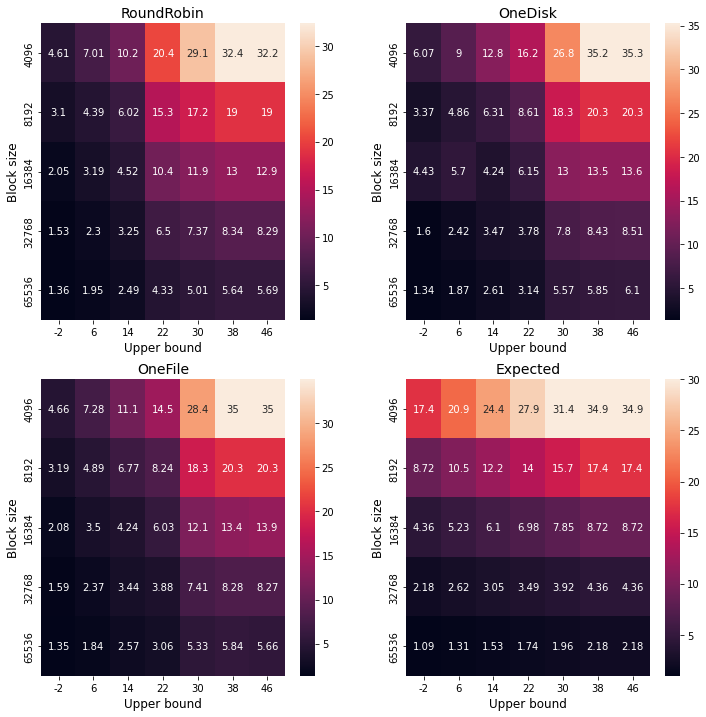

In [19]:
_, _, block_sizes, thread_numbers, upper_bounds = main_info('log_round_robin_02.csv')
thread_number = 1 # change it here to see what happens to others

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))

heatmap_from_benchmark('log_round_robin_02.csv', ax[0][0], thread_number)
ax[0][0].set_title('RoundRobin', fontsize=14)

heatmap_from_benchmark('log_one_disk_02.csv', ax[0][1], thread_number)
ax[0][1].set_title('OneDisk', fontsize=14)

heatmap_from_benchmark('log_one_file_02.csv', ax[1][0], thread_number)
ax[1][0].set_title('OneFile', fontsize=14)


data = []

for block_size in block_sizes:
    data.append([])
    for upper_bound in upper_bounds:
        data[-1].append((get_expected_ratio(block_size, upper_bound) / block_size) * (1e6 / 7))

sns.heatmap(data, annot=True, fmt='0.3g', ax=ax[1][1], vmin=1, vmax=30)
ax[1][1].set_title('Expected', fontsize=14)
ax[1][1].set_xticklabels([str(int(val)) for val in upper_bounds])
ax[1][1].set_yticklabels([str(round(val, 4)) for val in block_sizes])
ax[1][1].set_xlabel('Upper bound', fontsize=12)
ax[1][1].set_ylabel('Block size', fontsize=12)

## Worst case scenario
Trying to show that RoundRobin strategy is not always the most beneficial one.

In [8]:
class MixOfNormDistributions:
    def __init__(self, means, variances):
        self.means = means
        self.variances = variances
        self.n = len(means)
        
    def generate(self, block_num, block_size):
        r = np.array([])
        for i in range(block_num):
            j = i % self.n
            tmp = sps.norm(loc=self.means[j], scale=self.variances[j]).rvs(size=block_size)
            r = np.concatenate([r, tmp])
        return r
    
    def generate_blocks(self, block_num, block_size):
        r = []
        for i in range(block_num):
            j = i % self.n
            tmp = sps.norm(loc=self.means[j], scale=self.variances[j]).rvs(size=block_size)
            r.append(tmp)
        return r
    
    def show_hist(self, block_num, block_size):
        plt.figure(figsize=(15, 6))
        num = (block_num * block_size) / self.n
        for j in range(self.n):
            r = sps.norm(loc=self.means[j], scale=self.variances[j]).rvs(size=int(num))
            plt.hist(r, alpha=0.4, bins=80, density=True, label='BlockId {} mod 4 '.format(j))
        r = self.generate(block_num, block_size)
        # plt.hist(r, alpha=0.2, bins=50, density=True)
        
    def empirical_selectivity(self, bound):
        predicate = lambda x: x < bound
        r = self.generate(int(1e3), int(1e3))
        return np.mean(predicate(r))
    
    def _expected_part_of_loaded_blocks(self, block_size, distrib, bound):
        p = distrib.cdf(bound)
        return 1 - (1 - p)**block_size
    
    def expected_part_of_loaded_blocks(self, block_size, bound):
        sum_of_ps = 0
        for i in range(self.n):
            sum_of_ps += self._expected_part_of_loaded_blocks(block_size, 
                                                        sps.norm(loc=self.means[i], scale=self.variances[i]),
                                                        bound)
        return sum_of_ps / self.n

Text(0, 0.5, 'Density')

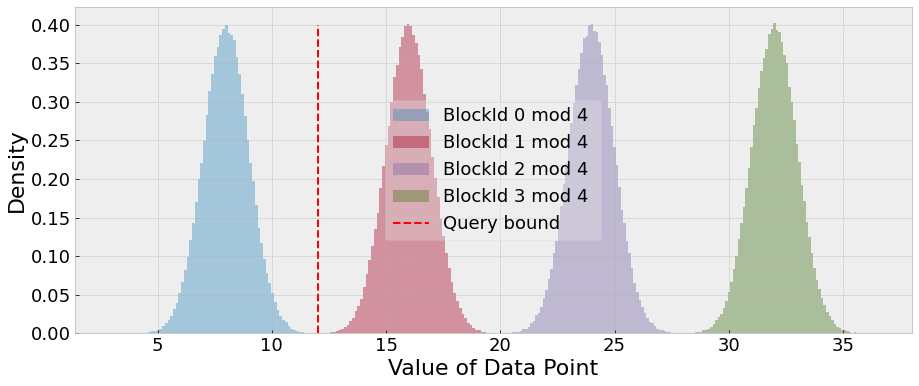

In [9]:
plt.style.use('bmh')
n = 4
means = np.linspace(8, 8 * n, n)
variances = np.ones(n)
mix = MixOfNormDistributions(means, variances)
mix.show_hist(1000, 1000)
plt.vlines(12, ymin=0, ymax=0.4, linestyles='dashed', colors='red', label='Query bound')
plt.legend(fontsize=18, loc='center', fancybox=True, framealpha=0.3)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Value of Data Point', fontsize=22)
plt.ylabel('Density', fontsize=22)

In [19]:
%ls

'Benchmarking results.ipynb'    log_one_disk_08.csv      log_round_robin_09.csv
 expected_ration.csv            log_one_disk_09.csv      log_round_robin_10.csv
 log_batched_placement_11.csv   log_one_disk_10.csv      log_shift6_08.csv
 log_modulo6_08.csv             log_one_file_02.csv      log_shift6_09.csv
 log_modulo6_09.csv             log_round_robin_01.csv   log_shift6_10.csv
 log_one_disk_01.csv            log_round_robin_02.csv
 log_one_disk_02.csv            log_round_robin_08.csv


In [20]:
print('RoundRobin survey:')
total_time('log_round_robin_10.csv')
print('Shift6 survey 08:')
total_time('log_shift6_10.csv')
print('OneDisk survey:')
total_time('log_one_disk_10.csv')

RoundRobin survey:
Scan time: 11.0 min, ExecuteQuery: 8.73 min, Total: 19.73 min
Shift6 survey 08:
Scan time: 10.38 min, ExecuteQuery: 8.64 min, Total: 19.020000000000003 min
OneDisk survey:
Scan time: 13.66 min, ExecuteQuery: 10.98 min, Total: 24.64 min


In [23]:
n = 6
means = np.linspace(8, 8 * n, n)
variances = np.ones(n)
mix = MixOfNormDistributions(means, variances)
_, _, block_sizes, thread_numbers, upper_bounds = main_info('log_round_robin_10.csv')
print(upper_bounds)

r = mix.generate(1000, 1000)

selectivities = []
for upper_bound in upper_bounds:
    selectivities.append(np.sum(np.where(r < upper_bound, 1, 0)) / len(r))
selectivities

[0, 4, 8, 12, 20, 28]


[0.0, 5e-06, 0.083387, 0.167003, 0.334002, 0.501003]

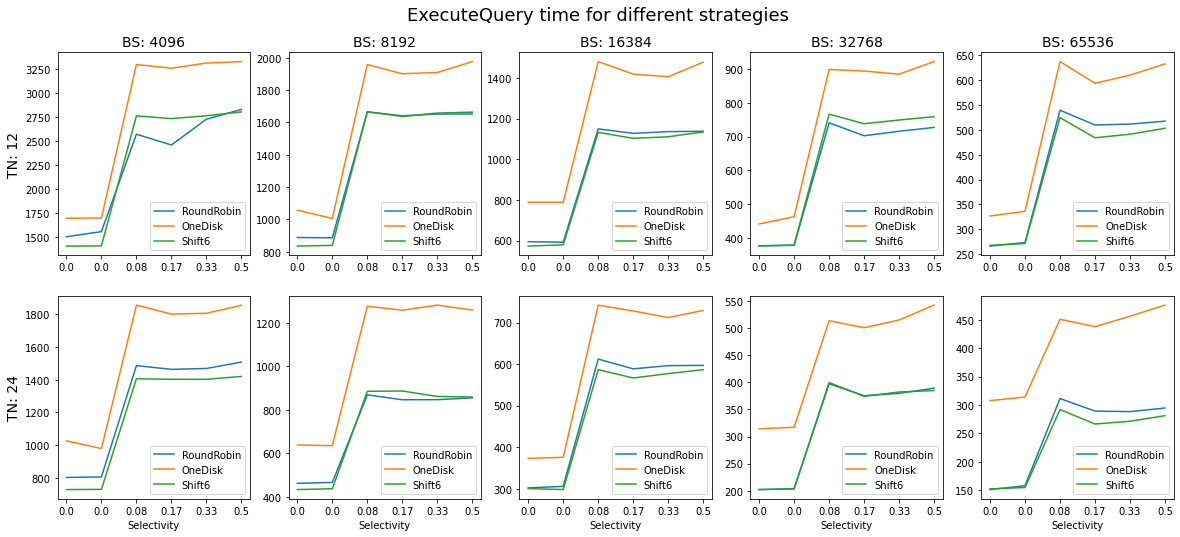

In [22]:
_, _, block_sizes, thread_numbers, upper_bounds = main_info('log_round_robin_10.csv')
fig, ax = plt.subplots(nrows=len(thread_numbers), ncols=len(block_sizes), figsize=(20, 8))

for i, thread_number in enumerate(thread_numbers):
    for j, block_size in enumerate(block_sizes):
        ax[0][j].set_title('BS: {}'.format(block_size), fontsize=14)
        ax[len(thread_numbers) - 1][j].set_xlabel('Selectivity')
        arr_round_robin = []
        arr_one_disk = []
        arr_shift6 = []
        for upper_bound in upper_bounds:
            arr_round_robin.append(get_mean_time('log_round_robin_10.csv', block_size, thread_number, upper_bound)[1])
            arr_one_disk.append(get_mean_time('log_one_disk_10.csv', block_size, thread_number, upper_bound)[1])
            arr_shift6.append(get_mean_time('log_shift6_10.csv', block_size, thread_number, upper_bound)[1])
        ax[i][j].plot(arr_round_robin, label='RoundRobin')
        ax[i][j].plot(arr_one_disk, label='OneDisk')
        ax[i][j].plot(arr_shift6, label='Shift6')
        ax[i][j].legend()
        ax[i][j].set_xticks(range(len(selectivities)))
        ax[i][j].set_xticklabels(labels=[str(np.round(a, 2)) for a in selectivities])
    ax[i][0].set_ylabel('TN: {}'.format(thread_number), fontsize=14)
    
plt.suptitle('ExecuteQuery time for different strategies', fontsize=18)
plt.subplots_adjust(top=0.9)

## BatchedRoundRobin strategy
Let's try placing blocks into batches and then using RoundRobin strategy to distribute batches across disks.

In [3]:
df = pd.read_csv('log_batched_placement_11.csv')
df.head()

data_size  block_size  batch_size  upper_bound  scan_time  \
0  2147483648        4096           1            0       3068   
1  2147483648        4096           1            0       1620   
2  2147483648        4096           1            0       3111   
3  2147483648        4096           1            0       1621   
4  2147483648        4096           1            0       3091   

   scan_thread_num  execute_query_time  execute_query_thread_num  scan_sum  \
0               12                1478                        12     19221   
1               24                 812                        24     19221   
2               12                1561                        12     19221   
3               24                 814                        24     19221   
4               12                1630                        12     19221   

   execute_query_sum  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0

In [25]:
def main_info(filename):
    df = get_df(filename)
    
    df_main = df[['block_size', 'scan_thread_num', 'scan_time', 'execute_query_time', 'upper_bound', 'batch_size']]
    df_grouped = df_main.groupby(['block_size', 'scan_thread_num', 'upper_bound', 'batch_size']).mean()

    block_sizes = []
    thread_numbers = []
    upper_bounds = []
    batch_sizes = []
    index_list = df_grouped.index.values.tolist()

    for block_size, thread_number, upper_bound, batch_size in index_list:
        if block_size not in block_sizes:
            block_sizes.append(block_size)
        if thread_number not in thread_numbers:
            thread_numbers.append(thread_number)
        if upper_bound not in upper_bounds:
            upper_bounds.append(upper_bound)
        if batch_size not in batch_sizes:
            batch_sizes.append(batch_size)
            
    return df, df_main, block_sizes, thread_numbers, upper_bounds, batch_sizes

In [36]:
df, df_main, block_sizes, thread_numbers, upper_bounds, batch_sizes = main_info('log_batched_placement_11.csv')
print('Block sizes: ' + str(block_sizes))
print('Thread numbers: ' + str(thread_numbers))
print('Upper bounds: ' + str(upper_bounds))
print('Batch sizes: ' + str(batch_sizes))

n = 7
means = np.linspace(8, 8 * n, n)
variances = np.ones(n)
mix = MixOfNormDistributions(means, variances)

r = mix.generate(1000, 1000)

selectivities = []
for upper_bound in upper_bounds:
    selectivities.append(np.sum(np.where(r < upper_bound, 1, 0)) / len(r))
print('Selectivities: ' + str(selectivities))

Block sizes: [4096, 8192, 16384, 32768, 65536]
Thread numbers: [12, 24]
Upper bounds: [0, 12, 20, 28]
Batch sizes: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
Selectivities: [0.0, 0.143005, 0.285999, 0.428998]


In [38]:
df = df[df['scan_thread_num'] == 12]
df = df[['block_size', 'execute_query_time', 'upper_bound', 'batch_size']]

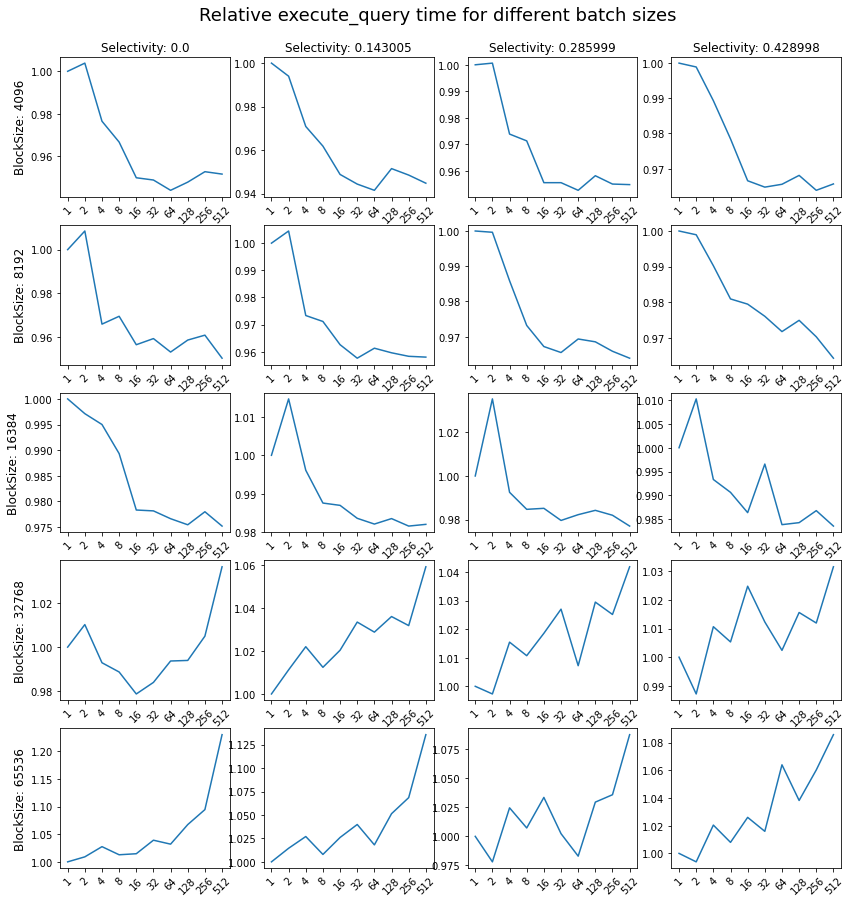

In [62]:
fig, ax = plt.subplots(nrows=len(block_sizes), ncols=len(selectivities), figsize=(14, 14))

for i, block_size in enumerate(block_sizes):
    for j, upper_bound in enumerate(upper_bounds):
        if i == 0:
            ax[i][j].set_title('Selectivity: {}'.format(selectivities[j]), fontsize=12)
        if j == 0:
            ax[i][j].set_ylabel('BlockSize: {}'.format(block_size), fontsize=12)
        df_curr = df[(df['block_size'] == block_size) & (df['upper_bound'] == upper_bound)]
        df_mean = df_curr.groupby('batch_size').mean()
        mean_time = np.array(df_mean['execute_query_time']) 
        ax[i][j].plot(mean_time / mean_time[0])
        ax[i][j].set_xticks(ticks=range(len(batch_sizes)))
        ax[i][j].set_xticklabels(labels=[str(batch_size) for batch_size in batch_sizes], rotation=45)
plt.suptitle('Relative execute_query time for different batch sizes', fontsize=18)
plt.subplots_adjust(top=0.93)

## Increase thread number
Previous experiments didn't show that *Shift6* or *Batch6* placement strategy is much better than *RoundRobin* one for the case of 6 well separated normal distributions though logically they should be beneficial. To understand what happens in more details, we usedd VTune profiler. It showed that the disks do not achieve maximum bandwidth, but it is easier to achieve it if we use more threads. For this reason we decided to run experiments with thread number from 96 to 6144.

In [3]:
%ls

'Benchmarking results.ipynb'    log_one_disk_08.csv      log_round_robin_09.csv
 expected_ration.csv            log_one_disk_09.csv      log_round_robin_10.csv
 log_batch4_13.csv              log_one_disk_10.csv      log_round_robin_12.csv
 log_batch6_12.csv              log_one_disk_12.csv      log_round_robin_13.csv
 log_batched_placement_11.csv   log_one_disk_13.csv      log_shift_13.csv
 log_modulo6_08.csv             log_one_file_02.csv      log_shift6_08.csv
 log_modulo6_09.csv             log_round_robin_01.csv   log_shift6_09.csv
 log_one_disk_01.csv            log_round_robin_02.csv   log_shift6_10.csv
 log_one_disk_02.csv            log_round_robin_08.csv   log_shift6_12.csv


In [7]:
data_size = 6442450944# first run
rr_df = get_df('log_round_robin_12.csv', data_size)
od_df = get_df('log_one_disk_12.csv', data_size)
s6_df = get_df('log_shift6_12.csv', data_size)
b6_df = get_df('log_batch6_12.csv', data_size)

print('RoundRobin survey:')
total_time('log_round_robin_13.csv', data_size)
print('OneDisk survey:')
total_time('log_one_disk_13.csv', data_size)
print('Shift6 survey:')
total_time('log_shift_13.csv', data_size)
print('Batch6 survey:')
total_time('log_batch4_13.csv', data_size)

RoundRobin survey:
Scan time: 2.22 min, ExecuteQuery: 2.17 min, Total: 4.390000000000001 min
OneDisk survey:
Scan time: 6.01 min, ExecuteQuery: 4.1 min, Total: 10.11 min
Shift6 survey:
Scan time: 2.21 min, ExecuteQuery: 1.86 min, Total: 4.07 min
Batch6 survey:
Scan time: 2.2 min, ExecuteQuery: 1.85 min, Total: 4.050000000000001 min


In [46]:
def get_times(filename, block_size, thread_number, upper_bound, data_size=2147483648):
    df_main, df_grouped, block_sizes, thread_numbers, _ = split_by_upper_bound(filename, upper_bound, data_size)
    stamp = df_main[(df_main['block_size'] == block_size) & (df_main['scan thread number'] == thread_number)]
    if upper_bound == -100:
        return list(stamp['scan time'])
    return list(stamp['execute_query time'])

def plot_times_per_thread(ax, filename, block_size, upper_bound, thread_numbers, label, data_size=2147483648):
    arr = []
    x = []
    y = []
    idx = 1
    if upper_bound == -100:
        idx = 0
    for i, thread_number in enumerate(thread_numbers):
        arr.append(get_mean_time(filename, block_size, thread_number, upper_bound, data_size)[idx])
        for time in get_times(filename, block_size, thread_number, upper_bound, data_size):
            x.append(i)
            y.append(time)
    ax.plot(arr, label=label, marker='o')
    # ax.scatter(x, y, label=label, alpha=0.2)
    

In [88]:
get_times('log_round_robin_12.csv', 4096, 48, 8, data_size)

[2425, 2394, 2425, 2364, 2410, 2404, 2382, 2384, 2396, 2398]

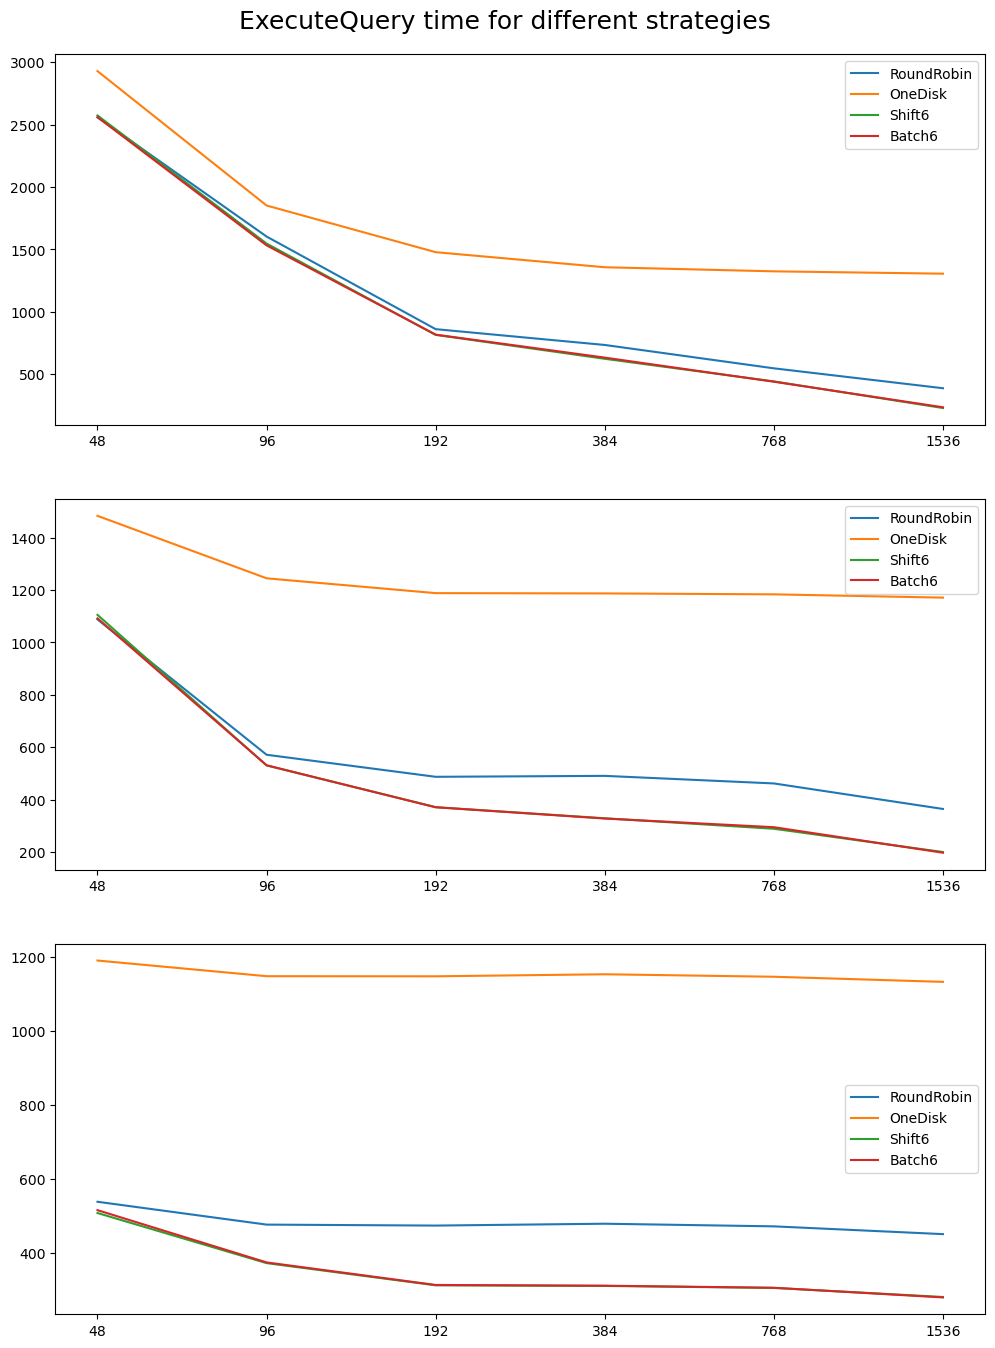

In [109]:

_, _, block_sizes, thread_numbers, upper_bounds = main_info('log_round_robin_13.csv', data_size)
    
fig, ax = plt.subplots(nrows=len(block_sizes), ncols=1, figsize=(12, 15))


upper_bound = upper_bounds[0]
for i, block_size in enumerate(block_sizes):
    plot_times_per_thread(ax[i], 'log_round_robin_13.csv', block_size, upper_bound, thread_numbers, 'RoundRobin', data_size)
    plot_times_per_thread(ax[i], 'log_one_disk_13.csv', block_size, upper_bound, thread_numbers, 'OneDisk', data_size)
    plot_times_per_thread(ax[i], 'log_shift_13.csv', block_size, upper_bound, thread_numbers, 'Shift6', data_size)
    plot_times_per_thread(ax[i], 'log_batch4_13.csv', block_size, upper_bound, thread_numbers, 'Batch6', data_size)
    ax[i].legend()
    ax[i].set_xticks(range(len(thread_numbers)))
    ax[i].set_xticklabels(labels=[str(a) for a in thread_numbers])

plt.suptitle('ExecuteQuery time for different strategies', fontsize=18)
plt.subplots_adjust(top=0.95)


Text(0, 0.5, 'Speed-Up relative to OneDisk')

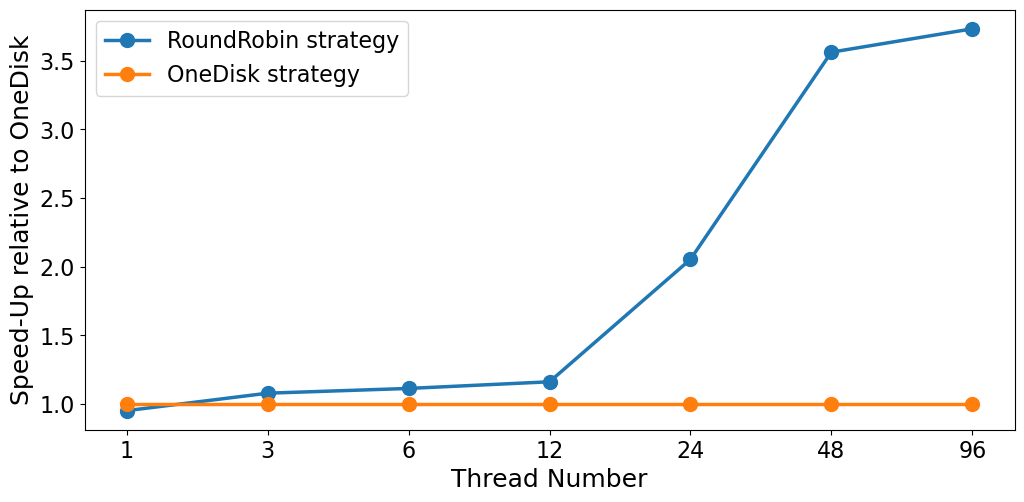

In [28]:
_, _, block_sizes, thread_numbers, upper_bounds = main_info('log_round_robin_15.csv', data_size)
block_sizes=[4096 * 16]
new_thread_numbers = []
for thread_number in thread_numbers:
    if thread_number < 192:
        new_thread_numbers.append(thread_number)
thread_numbers = new_thread_numbers

fig, ax = plt.subplots(nrows=len(block_sizes), ncols=1, figsize=(12, 5))


upper_bound = upper_bounds[0]
for i, block_size in enumerate(block_sizes):
    arr_rr = []
    arr_od = []
    for thread_number in thread_numbers:
        arr_rr.append(get_mean_time('log_round_robin_15.csv', block_size, thread_number, upper_bound, data_size)[1])
        arr_od.append(get_mean_time('log_one_disk_15.csv', block_size, thread_number, upper_bound, data_size)[1])
    arr_rr = np.array(arr_rr)
    arr_od = np.array(arr_od)
    ax.plot(arr_od / arr_rr, label='RoundRobin strategy', marker='o', linewidth=2.5, markersize=10)
    ax.plot(arr_od / arr_od, label='OneDisk strategy', marker='o', linewidth=2.5, markersize=10)
    plt.legend(fontsize=16)
    plt.xticks(ticks=range(len(thread_numbers)), labels=[str(a) for a in thread_numbers], fontsize=16)
    plt.yticks(fontsize=16)
    


plt.subplots_adjust(top=0.95)
plt.xlabel('Thread Number', fontsize=18)
plt.ylabel('Speed-Up relative to OneDisk', fontsize=18)

In [16]:
def plot_bandwidths_per_thread(ax, filename, block_size, upper_bound, thread_numbers, label, data_size=2147483648):
    arr = []
    x = []
    y = []
    idx = 1
    if upper_bound == -100:
        idx = 0
    for i, thread_number in enumerate(thread_numbers):
        arr.append(data_size / get_mean_time(filename, block_size, thread_number, upper_bound, data_size)[idx])
        for time in get_times(filename, block_size, thread_number, upper_bound, data_size):
            x.append(i)
            y.append(data_size / time)
    ax.plot(arr, label=label)
    ax.scatter(x, y, label=label, alpha=0.2)

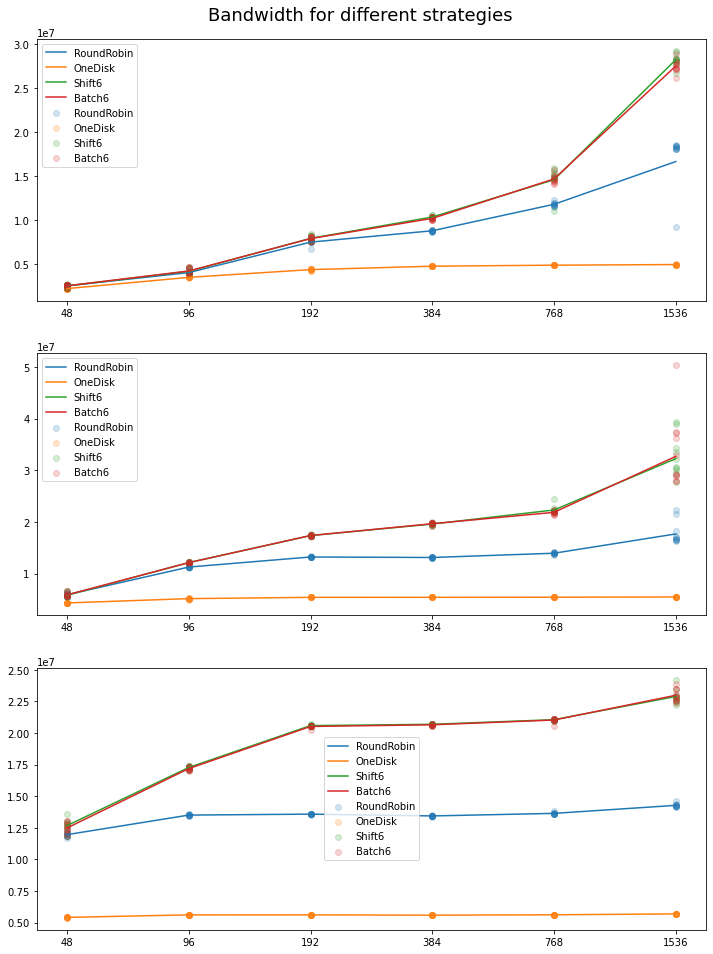

In [18]:
_, _, block_sizes, thread_numbers, upper_bounds = main_info('log_round_robin_13.csv', data_size)
fig, ax = plt.subplots(nrows=len(block_sizes), ncols=1, figsize=(12, 15))


upper_bound = upper_bounds[0]
for i, block_size in enumerate(block_sizes):
    plot_bandwidths_per_thread(ax[i], 'log_round_robin_13.csv', block_size, upper_bound, thread_numbers, 'RoundRobin', data_size)
    plot_bandwidths_per_thread(ax[i], 'log_one_disk_13.csv', block_size, upper_bound, thread_numbers, 'OneDisk', data_size)
    plot_bandwidths_per_thread(ax[i], 'log_shift_13.csv', block_size, upper_bound, thread_numbers, 'Shift6', data_size)
    plot_bandwidths_per_thread(ax[i], 'log_batch4_13.csv', block_size, upper_bound, thread_numbers, 'Batch6', data_size)
    ax[i].legend()
    ax[i].set_xticks(range(len(thread_numbers)))
    ax[i].set_xticklabels(labels=[str(a) for a in thread_numbers])

plt.suptitle('Bandwidth for different strategies', fontsize=18)
plt.subplots_adjust(top=0.95)


In order to have better comparison, we can look at scan time for each strategy. From the scan point of view, for each strategy blocks are spread equally among the disks (except for OneDisk strategy) so scan time should be equal for them.

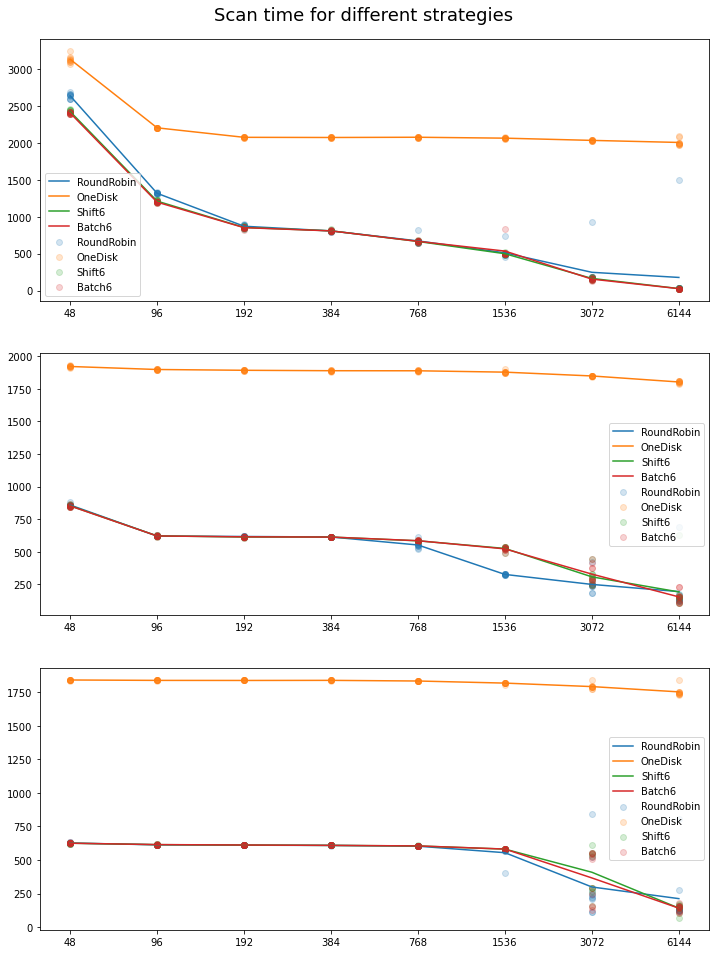

In [14]:
_, _, block_sizes, thread_numbers, upper_bounds = main_info('log_round_robin_12.csv', data_size)
fig, ax = plt.subplots(nrows=len(block_sizes), ncols=1, figsize=(12, 15))


upper_bound = -100
for i, block_size in enumerate(block_sizes):
    plot_times_per_thread(ax[i], 'log_round_robin_12.csv', block_size, upper_bound, thread_numbers, 'RoundRobin', data_size)
    plot_times_per_thread(ax[i], 'log_one_disk_12.csv', block_size, upper_bound, thread_numbers, 'OneDisk', data_size)
    plot_times_per_thread(ax[i], 'log_shift6_12.csv', block_size, upper_bound, thread_numbers, 'Shift6', data_size)
    plot_times_per_thread(ax[i], 'log_batch6_12.csv', block_size, upper_bound, thread_numbers, 'Batch6', data_size)
    ax[i].legend()
    ax[i].set_xticks(range(len(thread_numbers)))
    ax[i].set_xticklabels(labels=[str(a) for a in thread_numbers])

plt.suptitle('Scan time for different strategies', fontsize=18)
plt.subplots_adjust(top=0.95)

In [4]:
%ls

'Benchmarking results.ipynb'    log_one_disk_09.csv      log_round_robin_12.csv
 expected_ration.csv            log_one_disk_10.csv      log_round_robin_13.csv
 log_batch4_13.csv              log_one_disk_12.csv      log_round_robin_14.csv
 log_batch4_14.csv              log_one_disk_13.csv      log_shift_13.csv
 log_batch6_12.csv              log_one_disk_14.csv      log_shift_14.csv
 log_batched_placement_11.csv   log_one_file_02.csv      log_shift6_08.csv
 log_modulo6_08.csv             log_round_robin_01.csv   log_shift6_09.csv
 log_modulo6_09.csv             log_round_robin_02.csv   log_shift6_10.csv
 log_one_disk_01.csv            log_round_robin_08.csv   log_shift6_12.csv
 log_one_disk_02.csv            log_round_robin_09.csv
 log_one_disk_08.csv            log_round_robin_10.csv


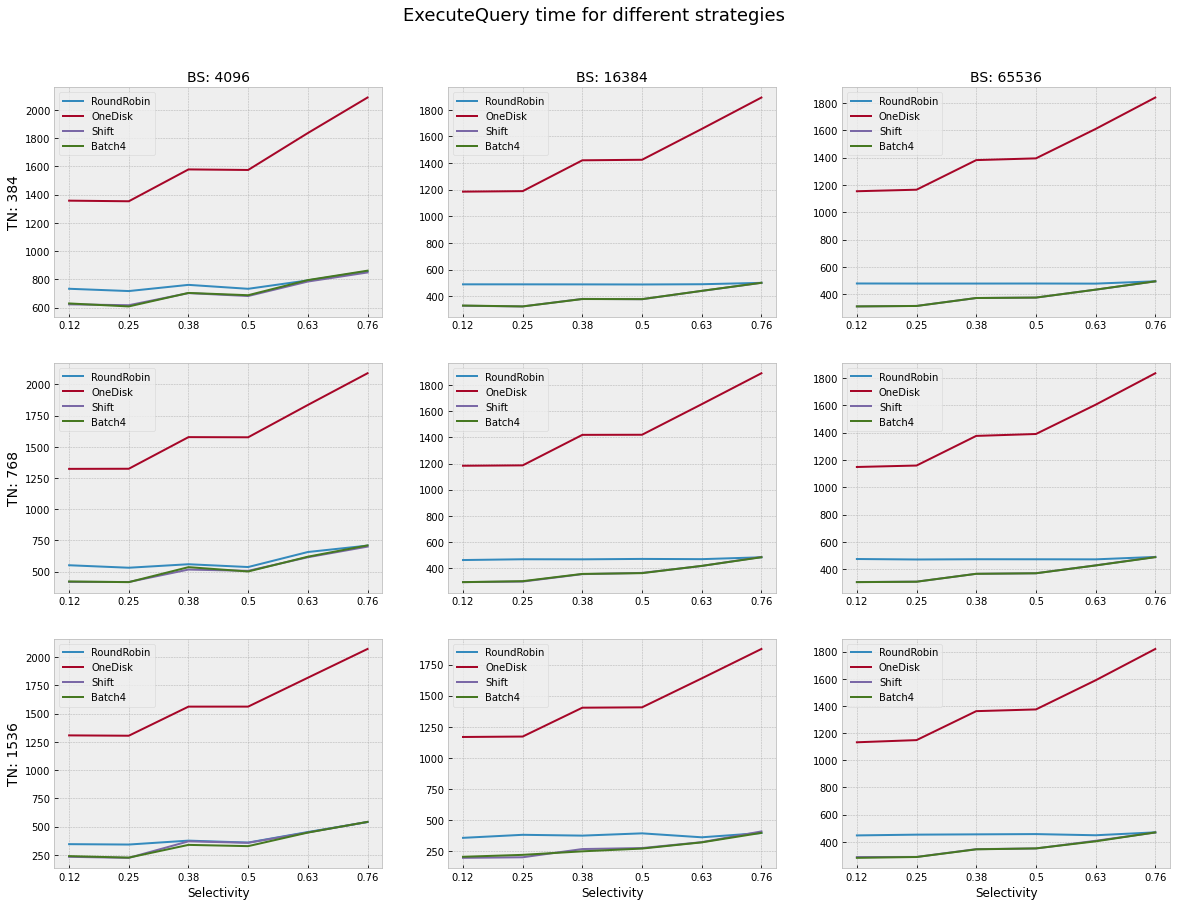

In [11]:
data_size = 6442450944# first run
_, _, block_sizes, thread_numbers, upper_bounds = main_info('log_round_robin_14.csv', data_size)
fig, ax = plt.subplots(nrows=len(thread_numbers), ncols=len(block_sizes), figsize=(20, 14))

n = 4
means = np.linspace(8, 8 * n, n)
variances = np.ones(n)
mix = MixOfNormDistributions(means, variances)

r = mix.generate(1000, 1000)

selectivities = []
for upper_bound in upper_bounds:
    selectivities.append(np.sum(np.where(r < upper_bound, 1, 0)) / len(r))
selectivities


for i, thread_number in enumerate(thread_numbers):
    for j, block_size in enumerate(block_sizes):
        ax[0][j].set_title('BS: {}'.format(block_size), fontsize=14)
        ax[len(thread_numbers) - 1][j].set_xlabel('Selectivity')
        arr_round_robin = []
        arr_one_disk = []
        arr_shift = []
        arr_batch = []
        for upper_bound in upper_bounds:
            arr_round_robin.append(get_mean_time('log_round_robin_14.csv', block_size, thread_number, upper_bound, data_size)[1])
            arr_one_disk.append(get_mean_time('log_one_disk_14.csv', block_size, thread_number, upper_bound, data_size)[1])
            arr_shift.append(get_mean_time('log_shift_14.csv', block_size, thread_number, upper_bound, data_size)[1])
            arr_batch.append(get_mean_time('log_batch4_14.csv', block_size, thread_number, upper_bound, data_size)[1])
        ax[i][j].plot(arr_round_robin, label='RoundRobin')
        ax[i][j].plot(arr_one_disk, label='OneDisk')
        ax[i][j].plot(arr_shift, label='Shift')
        ax[i][j].plot(arr_batch, label='Batch4')
        ax[i][j].legend()
        ax[i][j].set_xticks(range(len(upper_bounds)))
        ax[i][j].set_xticklabels(labels=[str(np.round(a, 2)) for a in selectivities])
    ax[i][0].set_ylabel('TN: {}'.format(thread_number), fontsize=14)
    
plt.suptitle('ExecuteQuery time for different strategies', fontsize=18)
plt.subplots_adjust(top=0.9)

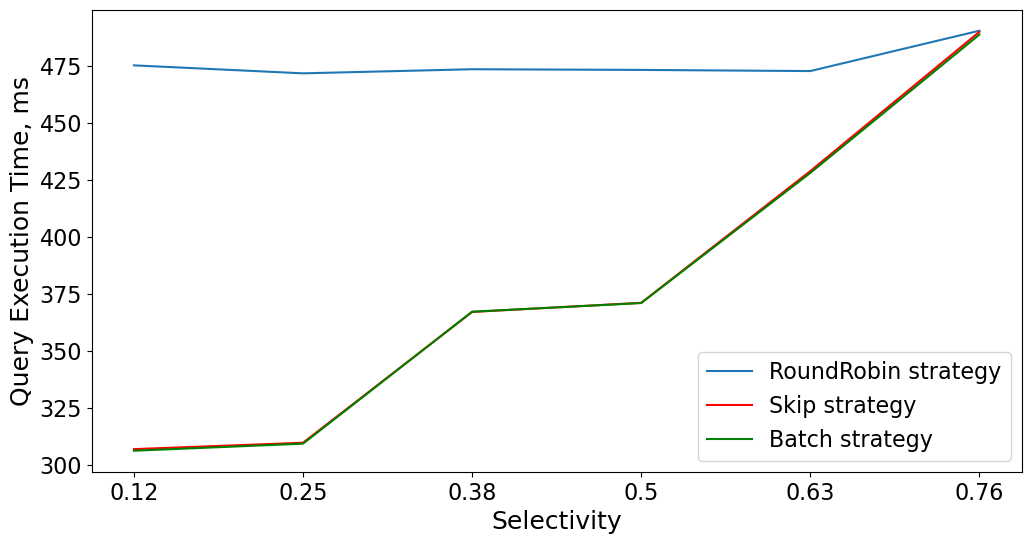

In [13]:
block_size = 4096 * 16
thread_number = 768

plt.style.use('default')
plt.figure(figsize=(12, 6))

plt.xlabel('Selectivity', fontsize=18)
plt.ylabel('Query Execution Time, ms', fontsize=18)

arr_round_robin = []
arr_one_disk = []
arr_shift = []
arr_batch = []
for upper_bound in upper_bounds:
    arr_round_robin.append(get_mean_time('log_round_robin_14.csv', block_size, thread_number, upper_bound, data_size)[1])
    arr_one_disk.append(get_mean_time('log_one_disk_14.csv', block_size, thread_number, upper_bound, data_size)[1])
    arr_shift.append(get_mean_time('log_shift_14.csv', block_size, thread_number, upper_bound, data_size)[1])
    arr_batch.append(get_mean_time('log_batch4_14.csv', block_size, thread_number, upper_bound, data_size)[1])
plt.plot(arr_round_robin, label='RoundRobin strategy')
# plt.plot(arr_one_disk, label='OneDisk')
plt.plot(arr_shift, label='Skip strategy', color='red')
plt.plot(arr_batch, label='Batch strategy', color='green')

plt.xticks(ticks=range(len(upper_bounds)), labels=[str(np.round(a, 2)) for a in selectivities], fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)


In [15]:
%ls

'Benchmarking results.ipynb'    log_one_disk_10.csv      log_round_robin_13.csv
 expected_ration.csv            log_one_disk_12.csv      log_round_robin_14.csv
 log_batch4_13.csv              log_one_disk_13.csv      log_round_robin_15.csv
 log_batch4_14.csv              log_one_disk_14.csv      log_round_robin_16.csv
 log_batch4_16.csv              log_one_disk_15.csv      log_round_robin_17.csv
 log_batch4_17.csv              log_one_disk_16.csv      log_shift_13.csv
 log_batch6_12.csv              log_one_disk_17.csv      log_shift_14.csv
 log_batched_placement_11.csv   log_one_file_02.csv      log_shift_16.csv
 log_modulo6_08.csv             log_round_robin_01.csv   log_shift_17.csv
 log_modulo6_09.csv             log_round_robin_02.csv   log_shift6_08.csv
 log_one_disk_01.csv            log_round_robin_08.csv   log_shift6_09.csv
 log_one_disk_02.csv            log_round_robin_09.csv   log_shift6_10.csv
 log_one_disk_08.csv            log_round_robin_10.csv   log_shift6_12.csv
 log

Text(0, 0.5, 'Query Execution Time, ms')

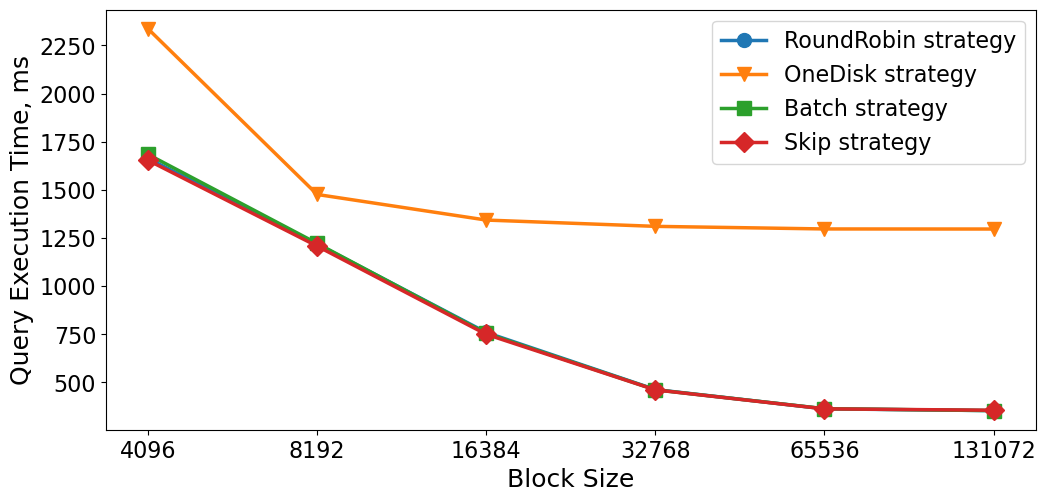

In [31]:
_, _, block_sizes, thread_numbers, upper_bounds = main_info('log_round_robin_17.csv', data_size)

new_thread_numbers = []
for thread_number in thread_numbers:
    if thread_number < 192:
        new_thread_numbers.append(thread_number)
thread_numbers = new_thread_numbers

plt.figure(figsize=(12, 5))


upper_bound = upper_bounds[0]

rr_arr = []
od_arr = []
b4_arr = []
s4_arr = []

thread_number = thread_numbers[0]
for i, block_size in enumerate(block_sizes):
    rr_arr.append(get_mean_time('log_round_robin_17.csv', block_size, thread_number, upper_bound, data_size)[1])
    od_arr.append(get_mean_time('log_one_disk_17.csv', block_size, thread_number, upper_bound, data_size)[1])
    b4_arr.append(get_mean_time('log_batch4_17.csv', block_size, thread_number, upper_bound, data_size)[1])
    s4_arr.append(get_mean_time('log_shift_17.csv', block_size, thread_number, upper_bound, data_size)[1])
    

plt.plot(rr_arr, label='RoundRobin strategy', marker='o', linewidth=2.5, markersize=10)
plt.plot(od_arr, label='OneDisk strategy', marker='v', linewidth=2.5, markersize=10)
plt.plot(b4_arr, label='Batch strategy', marker='s', linewidth=2.5, markersize=10)
plt.plot(s4_arr, label='Skip strategy', marker='D', linewidth=2.5, markersize=10)
plt.legend(fontsize=16)
plt.xticks(ticks=range(len(block_sizes)), labels=[str(a) for a in block_sizes], fontsize=16)
plt.yticks(fontsize=16)
    
plt.subplots_adjust(top=0.95)
plt.xlabel('Block Size', fontsize=18)
plt.ylabel('Query Execution Time, ms', fontsize=18)

In [7]:
%ls

'Benchmarking results.ipynb'    log_one_disk_10.csv      log_round_robin_14.csv
 expected_ration.csv            log_one_disk_12.csv      log_round_robin_15.csv
 log_batch4_13.csv              log_one_disk_13.csv      log_round_robin_16.csv
 log_batch4_14.csv              log_one_disk_14.csv      log_round_robin_17.csv
 log_batch4_16.csv              log_one_disk_15.csv      log_round_robin_18.csv
 log_batch4_17.csv              log_one_disk_16.csv      log_shift_13.csv
 log_batch4_18.csv              log_one_disk_17.csv      log_shift_14.csv
 log_batch6_12.csv              log_one_disk_18.csv      log_shift_16.csv
 log_batched_placement_11.csv   log_one_file_02.csv      log_shift_17.csv
 log_hardcoded_18.csv           log_round_robin_01.csv   log_shift_18.csv
 log_modulo6_08.csv             log_round_robin_02.csv   log_shift6_08.csv
 log_modulo6_09.csv             log_round_robin_08.csv   log_shift6_09.csv
 log_one_disk_01.csv            log_round_robin_09.csv   log_shift6_10.csv
 log_

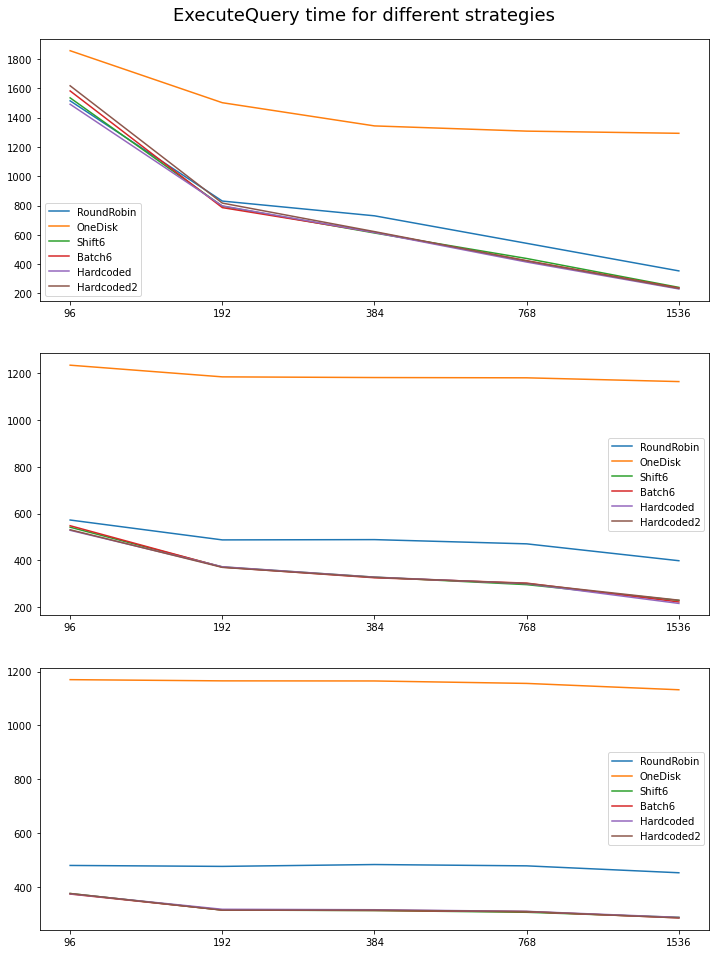

In [10]:
_, _, block_sizes, thread_numbers, upper_bounds = main_info('log_round_robin_18.csv', data_size)
    
fig, ax = plt.subplots(nrows=len(block_sizes), ncols=1, figsize=(12, 15))


upper_bound = upper_bounds[0]
for i, block_size in enumerate(block_sizes):
    plot_times_per_thread(ax[i], 'log_round_robin_18.csv', block_size, upper_bound, thread_numbers, 'RoundRobin', data_size)
    plot_times_per_thread(ax[i], 'log_one_disk_18.csv', block_size, upper_bound, thread_numbers, 'OneDisk', data_size)
    plot_times_per_thread(ax[i], 'log_shift_18.csv', block_size, upper_bound, thread_numbers, 'Shift6', data_size)
    plot_times_per_thread(ax[i], 'log_batch4_18.csv', block_size, upper_bound, thread_numbers, 'Batch6', data_size)
    plot_times_per_thread(ax[i], 'log_hardcoded_18.csv', block_size, upper_bound, thread_numbers, 'Hardcoded', data_size)
    plot_times_per_thread(ax[i], 'log_hardcoded2_18.csv', block_size, upper_bound, thread_numbers, 'Hardcoded2', data_size)
    ax[i].legend()
    ax[i].set_xticks(range(len(thread_numbers)))
    ax[i].set_xticklabels(labels=[str(a) for a in thread_numbers])

plt.suptitle('ExecuteQuery time for different strategies', fontsize=18)
plt.subplots_adjust(top=0.95)

In [1]:
%ls

'Benchmarking results.ipynb'    log_one_disk_09.csv      log_round_robin_14.csv
 expected_ration.csv            log_one_disk_10.csv      log_round_robin_15.csv
 log_batch4_13.csv              log_one_disk_12.csv      log_round_robin_16.csv
 log_batch4_14.csv              log_one_disk_13.csv      log_round_robin_17.csv
 log_batch4_16.csv              log_one_disk_14.csv      log_round_robin_18.csv
 log_batch4_17.csv              log_one_disk_15.csv      log_round_robin_19.csv
 log_batch4_18.csv              log_one_disk_16.csv      log_shift_13.csv
 log_batch6_12.csv              log_one_disk_17.csv      log_shift_14.csv
 log_batched_placement_11.csv   log_one_disk_18.csv      log_shift_16.csv
 log_hardcoded_18.csv           log_one_file_02.csv      log_shift_17.csv
 log_hardcoded_19.csv           log_round_robin_01.csv   log_shift_18.csv
 log_hardcoded2_18.csv          log_round_robin_02.csv   log_shift_19.csv
 log_modulo6_08.csv             log_round_robin_08.csv   log_shift6_08.csv
 

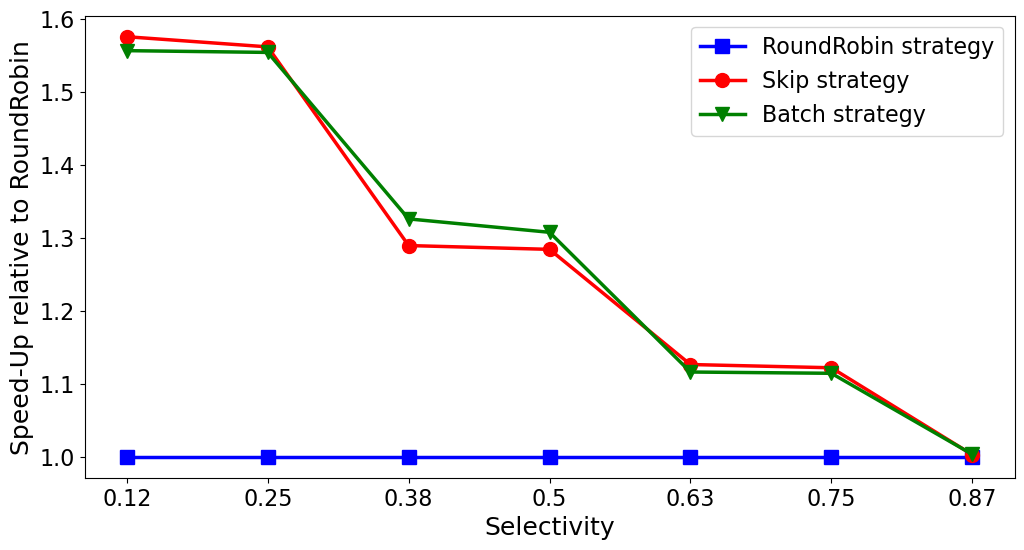

In [29]:
data_size = 6442450944# first run
_, _, block_sizes, thread_numbers, upper_bounds = main_info('log_round_robin_19.csv', data_size)
#fig, ax = plt.subplots(nrows=len(thread_numbers), ncols=len(block_sizes), figsize=(20, 14))

n = 4
means = np.linspace(8, 8 * n, n)
variances = np.ones(n)
mix = MixOfNormDistributions(means, variances)

r = mix.generate(1000, 1000)

selectivities = []
for upper_bound in upper_bounds:
    selectivities.append(np.sum(np.where(r < upper_bound, 1, 0)) / len(r))
selectivities

block_size = 4096 * 4
thread_number = 768

plt.style.use('default')
plt.figure(figsize=(12, 6))

plt.xlabel('Selectivity', fontsize=18)
plt.ylabel('Speed-Up relative to RoundRobin', fontsize=18)

arr_round_robin = []
arr_one_disk = []
arr_shift = []
arr_hardcoded = []
arr_batch = []
for upper_bound in upper_bounds:
    arr_round_robin.append(get_mean_time('log_round_robin_19.csv', block_size, thread_number, upper_bound, data_size)[1])
    # arr_one_disk.append(get_mean_time('log_one_disk_19.csv', block_size, thread_number, upper_bound, data_size)[1])
    arr_shift.append(get_mean_time('log_shift_19.csv', block_size, thread_number, upper_bound, data_size)[1])
    arr_hardcoded.append(get_mean_time('log_hardcoded_19.csv', block_size, thread_number, upper_bound, data_size)[1])
    arr_batch.append(get_mean_time('log_batch4_19.csv', block_size, thread_number, upper_bound, data_size)[1])
    
arr_round_robin = np.array(arr_round_robin)
arr_shift = np.array(arr_shift)
arr_hardcoded = np.array(arr_hardcoded)
arr_batch = np.array(arr_batch)
    
plt.plot(arr_round_robin / arr_round_robin, label='RoundRobin strategy', color='blue', marker='s', linewidth=2.5, markersize=10)
plt.plot(arr_round_robin / arr_shift, label='Skip strategy', color='red', marker='o', linewidth=2.5, markersize=10)
# plt.plot(arr_round_robin / arr_hardcoded, label='MIQP strategy', color='orange', marker='D', linewidth=2.5, markersize=10)
plt.plot(arr_round_robin / arr_batch, label='Batch strategy', color='green', marker='v', linewidth=2.5, markersize=10)

plt.xticks(ticks=range(len(upper_bounds)), labels=[str(np.round(a, 2)) for a in selectivities], fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)